XGBoost Classification - 'real-world' example: UCI Skin Segmentation dataset

GP ERM versus STP nu = 3 ERM (winner)

https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation

In [1]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
def ReadData():
    #Data in format [B G R Label] from
    data = np.genfromtxt('/home/ulsterconorc/Downloads/Skin_NonSkin.txt', dtype=np.int32)

    labels = data[:,3]
    data = data[:,0:3]

    return data, labels

data, labels = ReadData()

X = data
y = labels


In [3]:
### Bayesian Optimization - inputs:

obj_func = 'XGBoost'
n_test = 50 # test points
df = 3 # nu

util_loser = 'RegretMinimized'
util_winner = 'tRegretMinimized'
n_init = 5 # random initialisations

test_perc = 0.15
train_perc = 1 - test_perc
n_est = 2

obj_classifier = 'binary:logistic'
cov_func = squaredExponential()

In [4]:
### Objective function:

if obj_func == 'XGBoost':
    
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    y_global_orig = 1
    dim = 6
    
    max_iter = 30 

In [5]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [6]:
### Set-seeds:

run_num_1 = 111
run_num_2 = 113
run_num_3 = 3333
run_num_4 = 44444
run_num_5 = 5555
run_num_6 = 6
run_num_7 = 7777
run_num_8 = 887
run_num_9 = 99
run_num_10 = 1000
run_num_11 = 1113
run_num_12 = 1234
run_num_13 = 2345
run_num_14 = 88
run_num_15 = 1557
run_num_16 = 1666
run_num_17 = 717
run_num_18 = 8
run_num_19 = 1998
run_num_20 = 2000


In [7]:
### 4a. Add new acquisition functions: add CBM & ERM (Nyugen and Osborne, 2019) method .

### Inherits from class Acquisition()

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
            
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [8]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_loser_1 = GaussianProcess(cov_func)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, 
                       min_child_weight=min_child_weight,colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

loser_1 = GPGO(surrogate_loser_1, Acquisition_new(util_loser), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
loser_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_1 = loser_1.getResult()[0]
params_loser_1['max_depth'] = int(params_loser_1['max_depth'])
params_loser_1['min_child_weight'] = int(params_loser_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train1 = xgb.DMatrix(X_train1, y_train1)
dX_loser_test1 = xgb.DMatrix(X_test1, y_test1)
model_loser_1 = xgb.train(params_loser_1, dX_loser_train1)
pred_loser_1 = model_loser_1.predict(dX_loser_test1)

rmse_loser_1 = np.sqrt(mean_squared_error(pred_loser_1, y_test1))
rmse_loser_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.12170176  1.69069754 11.          0.92695323  3.          0.36579277]. 	  0.8890243937641641 	 0.9846806025668978
init   	 [ 1.49162957  0.22478325  6.          0.85613654 15.          0.19363322]. 	  0.8875985382508563 	 0.9846806025668978
init   	 [ 5.27957805  2.81819356 11.          0.81062146 14.          0.74826845]. 	  0.9846806025668978 	 0.9846806025668978
init   	 [3.81060005 6.24236569 7.         0.95038709 5.         0.9861745 ]. 	  0.9822369877610099 	 0.9846806025668978
init   	 [4.77531134 7.87990376 6.         0.78863691 6.         0.47918609]. 	  0.8869792272703285 	 0.9846806025668978
1      	 [4.26128727 7.00737964 6.53282638 0.87482164 5.4671733  0.74932303]. 	  0.9779738706123698 	 0.9846806025668978
2      	 [3.78128046 7.08001843 7.28349467 0.81606759 4.93438906 0.7105907 ]. 	  0.9823714094297742 	 0.9846806025668978
3      	 [4.43495488 6.67503667 7.45921469 0.91537911 5.27821457 0.94593868].

0.05920696212231716

In [9]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_loser_2 = GaussianProcess(cov_func)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

loser_2 = GPGO(surrogate_loser_2, Acquisition_new(util_loser), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
loser_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_2 = loser_2.getResult()[0]
params_loser_2['max_depth'] = int(params_loser_2['max_depth'])
params_loser_2['min_child_weight'] = int(params_loser_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train2 = xgb.DMatrix(X_train2, y_train2)
dX_loser_test2 = xgb.DMatrix(X_test2, y_test2)
model_loser_2 = xgb.train(params_loser_2, dX_loser_train2)
pred_loser_2 = model_loser_2.predict(dX_loser_test2)

rmse_loser_2 = np.sqrt(mean_squared_error(pred_loser_2, y_test2))
rmse_loser_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.51985493  0.73903599  7.          0.71824677 17.          0.61827209]. 	  0.8899125543587183 	 0.9907392220424587
init   	 [ 8.4047092   4.35120551 12.          0.84231905 16.          0.80172484]. 	  0.9902255407751176 	 0.9907392220424587
init   	 [ 6.42749368  9.61026168 10.          0.73363448 15.          0.84932207]. 	  0.9904943853572861 	 0.9907392220424587
init   	 [ 2.66008363  8.36685389  6.          0.92082163 12.          0.69999264]. 	  0.9907392220424587 	 0.9907392220424587
init   	 [ 1.74779478  2.17691512 12.          0.71794562  2.          0.48990646]. 	  0.8940700725633864 	 0.9907392220424587
1      	 [ 3.43112436  8.55676877  6.00000044  0.80756459 11.59622208  0.77577814]. 	  0.9901679379187686 	 0.9907392220424587
2      	 [ 3.40451653  8.03172613  5.80879517  0.89095486 12.28462328  0.78873698]. 	  0.9864761193439872 	 0.9907392220424587
3      	 [ 3.29659784  8.42987735  6.5650638   0.9979

0.064326562111266

In [10]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_loser_3 = GaussianProcess(cov_func)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

loser_3 = GPGO(surrogate_loser_3, Acquisition_new(util_loser), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
loser_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_3 = loser_3.getResult()[0]
params_loser_3['max_depth'] = int(params_loser_3['max_depth'])
params_loser_3['min_child_weight'] = int(params_loser_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train3 = xgb.DMatrix(X_train3, y_train3)
dX_loser_test3 = xgb.DMatrix(X_test3, y_test3)
model_loser_3 = xgb.train(params_loser_3, dX_loser_train3)
pred_loser_3 = model_loser_3.predict(dX_loser_test3)

rmse_loser_3 = np.sqrt(mean_squared_error(pred_loser_3, y_test3))
rmse_loser_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.51575607  1.09251275 13.          0.80377147 16.          0.31229624]. 	  0.8853133459581143 	 0.9850406749037081
init   	 [6.12794891 1.19652403 5.         0.74822174 8.         0.33695838]. 	  0.8834410179031171 	 0.9850406749037081
init   	 [ 6.21631223  4.4909976  10.          0.66764529  9.          0.77207323]. 	  0.9850406749037081 	 0.9850406749037081
init   	 [ 0.58127233  4.79918477 11.          0.64526552 15.          0.62431773]. 	  0.8862927047985528 	 0.9850406749037081
init   	 [ 5.76228258  0.67219724  7.          0.88228691 13.          0.29867219]. 	  0.8858222329336453 	 0.9850406749037081
1      	 [6.32090591 3.59919158 9.99999852 0.65981308 9.00000002 0.90744883]. 	  0.9845317837795499 	 0.9850406749037081
2      	 [6.69946221 4.09064519 9.42869281 0.7203414  8.71440443 0.80642204]. 	  0.9849254499001097 	 0.9850406749037081
3      	 [6.00755335 3.9957583  9.33568101 0.63043484 9.24569543 0.7107

0.0625316655752366

In [11]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_loser_4 = GaussianProcess(cov_func)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

loser_4 = GPGO(surrogate_loser_4, Acquisition_new(util_loser), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
loser_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_4 = loser_4.getResult()[0]
params_loser_4['max_depth'] = int(params_loser_4['max_depth'])
params_loser_4['min_child_weight'] = int(params_loser_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train4 = xgb.DMatrix(X_train4, y_train4)
dX_loser_test4 = xgb.DMatrix(X_test4, y_test4)
model_loser_4 = xgb.train(params_loser_4, dX_loser_train4)
pred_loser_4 = model_loser_4.predict(dX_loser_test4)

rmse_loser_4 = np.sqrt(mean_squared_error(pred_loser_4, y_test4))
rmse_loser_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.27423888  7.57027691 14.          0.71146658  9.          0.39774643]. 	  0.7961286970370575 	 0.9680361805433857
init   	 [ 2.32539597  3.72936196 10.          0.82732983  1.          0.94661358]. 	  0.9680361805433857 	 0.9680361805433857
init   	 [1.75719325 8.52964023 6.         0.7434712  8.         0.81674001]. 	  0.9546131048168407 	 0.9680361805433857
init   	 [ 6.71917565  6.77963281 14.          0.99125515  2.          0.14599602]. 	  0.7981786092152628 	 0.9680361805433857
init   	 [ 3.45494695  9.84067498 11.          0.7159999   7.          0.26316389]. 	  0.7957782443289703 	 0.9680361805433857
1      	 [ 2.54475597  3.9179364  10.87889719  0.88293341  1.          1.        ]. 	  0.9959049123393965 	 0.9959049123393965
2      	 [ 2.38764344  4.57153636 10.32997261  0.88759426  1.00000007  0.82653912]. 	  0.9680217732607336 	 0.9959049123393965
3      	 [ 3.11678541  4.07118715 10.23789093  1.          

0.05498246135836864

In [12]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_loser_5 = GaussianProcess(cov_func)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

loser_5 = GPGO(surrogate_loser_5, Acquisition_new(util_loser), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
loser_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_5 = loser_5.getResult()[0]
params_loser_5['max_depth'] = int(params_loser_5['max_depth'])
params_loser_5['min_child_weight'] = int(params_loser_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train5 = xgb.DMatrix(X_train5, y_train5)
dX_loser_test5 = xgb.DMatrix(X_test5, y_test5)
model_loser_5 = xgb.train(params_loser_5, dX_loser_train5)
pred_loser_5 = model_loser_5.predict(dX_loser_test5)

rmse_loser_5 = np.sqrt(mean_squared_error(pred_loser_5, y_test5))
rmse_loser_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.57353274  5.41760627  8.          0.53710825 19.          0.26034376]. 	  0.8874977192853896 	 0.9875226863588296
init   	 [5.17826437 9.78817462 5.         0.84048437 6.         0.79712615]. 	  0.9790156454078135 	 0.9875226863588296
init   	 [ 9.84476201  9.65484856  5.          0.59464714 19.          0.34528747]. 	  0.8875793339107304 	 0.9875226863588296
init   	 [ 9.17476842  4.53262239 13.          0.64368565 10.          0.515308  ]. 	  0.8874977192853896 	 0.9875226863588296
init   	 [ 8.66719465  7.99685372 12.          0.79833571 17.          0.72443466]. 	  0.9875226863588296 	 0.9875226863588296
1      	 [ 8.04875096  7.60250855 11.99995594  0.72320561 16.47912318  0.65900801]. 	  0.8875793339107304 	 0.9875226863588296
2      	 [ 8.28903908  7.4554031  11.46697547  0.7748613  17.2901625   0.64952432]. 	  0.8875025212520042 	 0.9875226863588296
3      	 [ 7.85136279  8.22426624 11.89960844  0.6635413  1

0.06481725208023831

In [13]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_loser_6 = GaussianProcess(cov_func)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

loser_6 = GPGO(surrogate_loser_6, Acquisition_new(util_loser), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
loser_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_6 = loser_6.getResult()[0]
params_loser_6['max_depth'] = int(params_loser_6['max_depth'])
params_loser_6['min_child_weight'] = int(params_loser_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train6 = xgb.DMatrix(X_train6, y_train6)
dX_loser_test6 = xgb.DMatrix(X_test6, y_test6)
model_loser_6 = xgb.train(params_loser_6, dX_loser_train6)
pred_loser_6 = model_loser_6.predict(dX_loser_test6)

rmse_loser_6 = np.sqrt(mean_squared_error(pred_loser_6, y_test6))
rmse_loser_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  0.8573338214862317 	 0.989121369524546
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  0.8635317250300133 	 0.989121369524546
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  0.989121369524546 	 0.989121369524546
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  0.8589277181043972 	 0.989121369524546
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  0.8624707456178685 	 0.989121369524546
1      	 [ 5.37727055  6.24418657 13.99999715  0.78872166 12.90500021  0.66278343]. 	  0.8568442162918638 	 0.989121369524546
2      	 [ 5.10602925  5.87911652 14.00000117  0.71578879 11.93143582  0.71227668]. 	  0.9892269854782749 	 0.9892269854782749
3      	 [ 5.19776217  6.47317782 14.62821187  0.72116838 12.09222515  0.61050

0.0601842959615071

In [14]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_loser_7 = GaussianProcess(cov_func)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

loser_7 = GPGO(surrogate_loser_7, Acquisition_new(util_loser), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
loser_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_7 = loser_7.getResult()[0]
params_loser_7['max_depth'] = int(params_loser_7['max_depth'])
params_loser_7['min_child_weight'] = int(params_loser_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train7 = xgb.DMatrix(X_train7, y_train7)
dX_loser_test7 = xgb.DMatrix(X_test7, y_test7)
model_loser_7 = xgb.train(params_loser_7, dX_loser_train7)
pred_loser_7 = model_loser_7.predict(dX_loser_test7)

rmse_loser_7 = np.sqrt(mean_squared_error(pred_loser_7, y_test7))
rmse_loser_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.11505126  6.92324143 13.          0.94046175 12.          0.3650384 ]. 	  0.8297634105475625 	 0.9886700606517818
init   	 [ 5.15357029  9.0066636   6.          0.74104227 15.          0.8966337 ]. 	  0.9814544396474091 	 0.9886700606517818
init   	 [ 2.63548913  9.6610934  14.          0.64712408  1.          0.80820948]. 	  0.9886700606517818 	 0.9886700606517818
init   	 [ 1.40821426  1.72758589 12.          0.70495069  5.          0.86632715]. 	  0.9884588284677487 	 0.9886700606517818
init   	 [2.85126987 2.73434054 7.         0.88394733 8.         0.65545939]. 	  0.8285920024977876 	 0.9886700606517818
1      	 [ 3.11101452  9.28260134 13.36659845  0.68217491  1.21135528  0.82304321]. 	  0.9893085666380245 	 0.9893085666380245
2      	 [ 3.38436655  9.99954672 13.74124648  0.53563981  1.08616909  0.99570233]. 	  0.9882907964898706 	 0.9893085666380245
3      	 [ 2.67569874  9.97902812 13.20884853  0.5034907   

0.06331398538451588

In [15]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_loser_8 = GaussianProcess(cov_func)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

loser_8 = GPGO(surrogate_loser_8, Acquisition_new(util_loser), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
loser_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_8 = loser_8.getResult()[0]
params_loser_8['max_depth'] = int(params_loser_8['max_depth'])
params_loser_8['min_child_weight'] = int(params_loser_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train8 = xgb.DMatrix(X_train8, y_train8)
dX_loser_test8 = xgb.DMatrix(X_test8, y_test8)
model_loser_8 = xgb.train(params_loser_8, dX_loser_train8)
pred_loser_8 = model_loser_8.predict(dX_loser_test8)

rmse_loser_8 = np.sqrt(mean_squared_error(pred_loser_8, y_test8))
rmse_loser_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.09499875  0.42215015  7.          0.62339266 17.          0.52353668]. 	  0.8894852354753713 	 0.8894852354753713
init   	 [ 9.1272854   1.60640294  7.          0.68662086 17.          0.1484676 ]. 	  0.8891731849480878 	 0.8894852354753713
init   	 [ 6.02074372  4.29318577 11.          0.77432386  5.          0.51209718]. 	  0.8891155762837446 	 0.8894852354753713
init   	 [2.81633282 5.85246014 5.         0.54171534 6.         0.39755341]. 	  0.8890483697707694 	 0.8894852354753713
init   	 [ 6.23734577  3.09242107 14.          0.6186205  15.          0.51761313]. 	  0.8892067935977129 	 0.8894852354753713
1      	 [6.07385922e-01 1.77561699e-04 7.70123324e+00 5.30464199e-01
 1.66493835e+01 5.76554988e-01]. 	  0.8897972824072298 	 0.8897972824072298
2      	 [ 0.99314801  0.80566768  7.92019244  0.66762468 17.04262647  0.66074261]. 	  0.889475634031314 	 0.8897972824072298
3      	 [ 1.59221857  0.1126534   7.7311

0.0646401566773533

In [16]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_loser_9 = GaussianProcess(cov_func)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

loser_9 = GPGO(surrogate_loser_9, Acquisition_new(util_loser), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
loser_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_9 = loser_9.getResult()[0]
params_loser_9['max_depth'] = int(params_loser_9['max_depth'])
params_loser_9['min_child_weight'] = int(params_loser_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train9 = xgb.DMatrix(X_train9, y_train9)
dX_loser_test9 = xgb.DMatrix(X_test9, y_test9)
model_loser_9 = xgb.train(params_loser_9, dX_loser_train9)
pred_loser_9 = model_loser_9.predict(dX_loser_test9)

rmse_loser_9 = np.sqrt(mean_squared_error(pred_loser_9, y_test9))
rmse_loser_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.72278559  4.88078399 14.          0.8670313   5.          0.82724497]. 	  0.968425042143454 	 0.968425042143454
init   	 [ 5.6561742   2.97622499 12.          0.75688314 17.          0.10614316]. 	  0.7923984116619751 	 0.968425042143454
init   	 [7.69793028 7.46767101 7.         0.74680784 9.         0.93605355]. 	  0.9563894026036909 	 0.968425042143454
init   	 [ 3.95454044  9.73956297 10.          0.66345176 13.          0.59891121]. 	  0.7929360981296009 	 0.968425042143454
init   	 [ 2.92269116  8.1614236  14.          0.61078869 19.          0.13894609]. 	  0.7908333515969722 	 0.968425042143454
1      	 [ 7.60863201  5.02369233 14.          0.86260025  4.76578023  0.79156586]. 	  0.9682042036061591 	 0.968425042143454
2      	 [ 7.01867964  5.61674133 14.30475738  0.94188818  4.70375305  0.99335795]. 	  0.9686170722691062 	 0.9686170722691062
3      	 [ 6.94707024  5.15822773 13.77895865  0.85858015  4.19716

0.06109824360218985

In [17]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_loser_10 = GaussianProcess(cov_func)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

loser_10 = GPGO(surrogate_loser_10, Acquisition_new(util_loser), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
loser_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_10 = loser_10.getResult()[0]
params_loser_10['max_depth'] = int(params_loser_10['max_depth'])
params_loser_10['min_child_weight'] = int(params_loser_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train10 = xgb.DMatrix(X_train10, y_train10)
dX_loser_test10 = xgb.DMatrix(X_test10, y_test10)
model_loser_10 = xgb.train(params_loser_10, dX_loser_train10)
pred_loser_10 = model_loser_10.predict(dX_loser_test10)

rmse_loser_10 = np.sqrt(mean_squared_error(pred_loser_10, y_test10))
rmse_loser_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.53589585  1.15006943  6.          0.93623727 14.          0.13663866]. 	  0.8925625895791941 	 0.9854871661142187
init   	 [ 3.97194461  2.33132197 14.          0.9533253  19.          0.26403087]. 	  0.8916888516708369 	 0.9854871661142187
init   	 [ 7.43539415  0.69582081  9.          0.9763222  11.          0.12608349]. 	  0.8916264438056544 	 0.9854871661142187
init   	 [ 9.82027485  3.39637684  9.          0.78522537 19.          0.87618843]. 	  0.9854871661142187 	 0.9854871661142187
init   	 [ 0.57576207  5.82646405 12.          0.77704362 18.          0.11865044]. 	  0.8923177518569682 	 0.9854871661142187
1      	 [ 9.99921704  3.04883105  8.50435002  0.87840248 19.64332185  0.82478253]. 	  0.9856695950032489 	 0.9856695950032489
2      	 [ 9.23926256  3.00793564  8.47774568  0.86206135 19.17157042  0.78704598]. 	  0.9858280233936165 	 0.9858280233936165
3      	 [ 9.81193127  3.58930446  8.14938051  0.9479

0.06738310386109525

In [18]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_loser_11 = GaussianProcess(cov_func)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

loser_11 = GPGO(surrogate_loser_11, Acquisition_new(util_loser), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
loser_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_11 = loser_11.getResult()[0]
params_loser_11['max_depth'] = int(params_loser_11['max_depth'])
params_loser_11['min_child_weight'] = int(params_loser_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train11 = xgb.DMatrix(X_train11, y_train11)
dX_loser_test11 = xgb.DMatrix(X_test11, y_test11)
model_loser_11 = xgb.train(params_loser_11, dX_loser_train11)
pred_loser_11 = model_loser_11.predict(dX_loser_test11)

rmse_loser_11 = np.sqrt(mean_squared_error(pred_loser_11, y_test11))
rmse_loser_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.81035663  8.2124785   9.          0.68487173 15.          0.28207988]. 	  0.8223029792710461 	 0.9791740729684557
init   	 [ 4.91906771  1.38558332  6.          0.618878   19.          0.10263204]. 	  0.8222694087887517 	 0.9791740729684557
init   	 [ 5.23426175  1.89971159 13.          0.76313779 17.          0.46597853]. 	  0.8261292537401452 	 0.9791740729684557
init   	 [ 4.0204056   3.75167577  9.          0.86204818 17.          0.26560056]. 	  0.8280591870022723 	 0.9791740729684557
init   	 [8.8704459  5.64917815 5.         0.51406171 1.         0.82826731]. 	  0.9791740729684557 	 0.9791740729684557
1      	 [8.02776449 5.47540798 5.27568131 0.55701687 1.00000002 0.68903624]. 	  0.9810991916797995 	 0.9810991916797995
2      	 [8.67133264 5.02712129 5.49265605 0.55613132 1.3803911  0.77636521]. 	  0.9810991916797995 	 0.9810991916797995
3      	 [8.58941355 5.13466314 5.00072391 0.500018   1.0000999  0.1466

0.06350779003544968

In [19]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_loser_12 = GaussianProcess(cov_func)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

loser_12 = GPGO(surrogate_loser_12, Acquisition_new(util_loser), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
loser_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_12 = loser_12.getResult()[0]
params_loser_12['max_depth'] = int(params_loser_12['max_depth'])
params_loser_12['min_child_weight'] = int(params_loser_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train12 = xgb.DMatrix(X_train12, y_train12)
dX_loser_test12 = xgb.DMatrix(X_test12, y_test12)
model_loser_12 = xgb.train(params_loser_12, dX_loser_train12)
pred_loser_12 = model_loser_12.predict(dX_loser_test12)

rmse_loser_12 = np.sqrt(mean_squared_error(pred_loser_12, y_test12))
rmse_loser_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.9151945   6.22108771  9.          0.89267929 16.          0.87460279]. 	  0.9904271937791528 	 0.9904271937791528
init   	 [ 1.50636966  1.98518759 11.          0.67890863 17.          0.5381501 ]. 	  0.88993656488314 	 0.9904271937791528
init   	 [ 3.31015428  8.02639569  7.          0.75154158 13.          0.11992952]. 	  0.8906470902736388 	 0.9904271937791528
init   	 [ 2.90728553  2.46394443  5.          0.94461307 17.          0.43194161]. 	  0.8861198789973782 	 0.9904271937791528
init   	 [ 9.33140102  6.51378143  8.          0.76907392 18.          0.38515251]. 	  0.8871856699871236 	 0.9904271937791528
1      	 [ 2.20850053  6.60048665  8.57964171  0.86300391 15.36962087  0.71585139]. 	  0.9902207578919282 	 0.9904271937791528
2      	 [ 1.45617388  6.55019346  9.05143081  0.82970662 15.32482527  0.76226071]. 	  0.9905136049779549 	 0.9905136049779549
3      	 [ 2.21722526  6.25514507  9.38183001  0.756138

0.07131099845430462

In [20]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_loser_13 = GaussianProcess(cov_func)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

loser_13 = GPGO(surrogate_loser_13, Acquisition_new(util_loser), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
loser_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_13 = loser_13.getResult()[0]
params_loser_13['max_depth'] = int(params_loser_13['max_depth'])
params_loser_13['min_child_weight'] = int(params_loser_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train13 = xgb.DMatrix(X_train13, y_train13)
dX_loser_test13 = xgb.DMatrix(X_test13, y_test13)
model_loser_13 = xgb.train(params_loser_13, dX_loser_train13)
pred_loser_13 = model_loser_13.predict(dX_loser_test13)

rmse_loser_13 = np.sqrt(mean_squared_error(pred_loser_13, y_test13))
rmse_loser_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.60644309  4.13600652  6.          0.61497171 13.          0.31340376]. 	  0.8166764439986761 	 0.9879595510260936
init   	 [ 4.54930866  5.99748524  8.          0.75090625 13.          0.20817186]. 	  0.8204018598829208 	 0.9879595510260936
init   	 [8.80885505 2.26218951 9.         0.95881521 6.         0.90500855]. 	  0.9879595510260936 	 0.9879595510260936
init   	 [ 6.39630194  9.30791981  8.          0.77550908 10.          0.88560697]. 	  0.9870906082391165 	 0.9879595510260936
init   	 [ 8.71308214  7.36202238 13.          0.60528576  7.          0.38868957]. 	  0.8188272073625565 	 0.9879595510260936
1      	 [8.75818261 1.82535264 9.73293248 0.96041632 6.24428973 0.73785956]. 	  0.9879355470702414 	 0.9879595510260936
2      	 [8.77662081 2.71131097 9.72080185 0.86534868 6.18008817 0.71654634]. 	  0.9877243135033327 	 0.9879595510260936
3      	 [9.49297492 2.25702224 9.53230378 0.95481676 6.19220421 0.8787

0.06176950917580233

In [21]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_loser_14 = GaussianProcess(cov_func)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

loser_14 = GPGO(surrogate_loser_14, Acquisition_new(util_loser), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
loser_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_14 = loser_14.getResult()[0]
params_loser_14['max_depth'] = int(params_loser_14['max_depth'])
params_loser_14['min_child_weight'] = int(params_loser_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train14 = xgb.DMatrix(X_train14, y_train14)
dX_loser_test14 = xgb.DMatrix(X_test14, y_test14)
model_loser_14 = xgb.train(params_loser_14, dX_loser_train14)
pred_loser_14 = model_loser_14.predict(dX_loser_test14)

rmse_loser_14 = np.sqrt(mean_squared_error(pred_loser_14, y_test14))
rmse_loser_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.47551049 5.07149688 9.         0.9481426  2.         0.30826454]. 	  0.8841083588522155 	 0.985981635228031
init   	 [1.30128292 8.51503709 6.         0.58757726 8.         0.65878816]. 	  0.8847900532901706 	 0.985981635228031
init   	 [ 1.87389374  2.97833637 11.          0.92510013  4.          0.27446484]. 	  0.8861919064379334 	 0.985981635228031
init   	 [ 9.80899716  0.11774133 11.          0.53577929  6.          0.38130944]. 	  0.8891587951046561 	 0.985981635228031
init   	 [ 6.4601046   0.32698917 10.          0.67912907 15.          0.96967672]. 	  0.985981635228031 	 0.985981635228031
1      	 [ 6.04704707  0.         10.73515922  0.73996947 14.99999999  0.99943441]. 	  0.9855639564395027 	 0.985981635228031
2      	 [ 6.6277366   0.47581753 10.72604035  0.68437373 15.44088114  0.79160505]. 	  0.9863032877524404 	 0.9863032877524404
3      	 [ 5.90276298  0.42258861 10.29514601  0.58639411 15.61451785  0

0.053341897983467085

In [22]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_loser_15 = GaussianProcess(cov_func)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

loser_15 = GPGO(surrogate_loser_15, Acquisition_new(util_loser), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
loser_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_15 = loser_15.getResult()[0]
params_loser_15['max_depth'] = int(params_loser_15['max_depth'])
params_loser_15['min_child_weight'] = int(params_loser_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train15 = xgb.DMatrix(X_train15, y_train15)
dX_loser_test15 = xgb.DMatrix(X_test15, y_test15)
model_loser_15 = xgb.train(params_loser_15, dX_loser_train15)
pred_loser_15 = model_loser_15.predict(dX_loser_test15)

rmse_loser_15 = np.sqrt(mean_squared_error(pred_loser_15, y_test15))
rmse_loser_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.64315424  8.97297685  6.          0.81493635 11.          0.33008564]. 	  0.7975400806883499 	 0.9868697857411816
init   	 [9.51455383 9.60803032 5.         0.68485728 1.         0.30145081]. 	  0.7964118845990855 	 0.9868697857411816
init   	 [ 8.11809889  6.32508536  7.          0.61766329 19.          0.51383159]. 	  0.7990859351689633 	 0.9868697857411816
init   	 [ 7.28571251  5.36071389 10.          0.76240297 12.          0.12035683]. 	  0.7997340414931001 	 0.9868697857411816
init   	 [ 6.80847768  3.59767194 14.          0.51365585 16.          0.89730673]. 	  0.9868697857411816 	 0.9868697857411816
1      	 [ 6.86771762  3.93133782 13.40798203  0.50594722 15.40798203  0.82812472]. 	  0.9871530246071581 	 0.9871530246071581
2      	 [ 7.48953172  3.50387631 13.8742387   0.5        15.44248454  0.94154453]. 	  0.9870234034529592 	 0.9871530246071581
3      	 [ 6.68745217  3.32291849 13.98016362  0.55847271 1

0.05849860225050029

In [23]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_loser_16 = GaussianProcess(cov_func)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

loser_16 = GPGO(surrogate_loser_16, Acquisition_new(util_loser), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
loser_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_16 = loser_16.getResult()[0]
params_loser_16['max_depth'] = int(params_loser_16['max_depth'])
params_loser_16['min_child_weight'] = int(params_loser_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train16 = xgb.DMatrix(X_train16, y_train16)
dX_loser_test16 = xgb.DMatrix(X_test16, y_test16)
model_loser_16 = xgb.train(params_loser_16, dX_loser_train16)
pred_loser_16 = model_loser_16.predict(dX_loser_test16)

rmse_loser_16 = np.sqrt(mean_squared_error(pred_loser_16, y_test16))
rmse_loser_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.63948332 3.16366002 7.         0.75395583 1.         0.56999262]. 	  0.8862591155624773 	 0.9857703856869544
init   	 [ 3.3426621   9.77029134 14.          0.93751218 17.          0.80549151]. 	  0.9857703856869544 	 0.9857703856869544
init   	 [ 3.36871073  4.8308288  13.          0.91984982 14.          0.48829226]. 	  0.8862111023959116 	 0.9857703856869544
init   	 [ 8.84540736  1.59826081  8.          0.75772888 14.          0.29029227]. 	  0.8862879265323566 	 0.9857703856869544
init   	 [ 7.74981136  8.34377636 13.          0.83182409 15.          0.19378622]. 	  0.8859086345058471 	 0.9857703856869544
1      	 [ 8.48805787  2.49755915  8.31841837  0.67868543 14.00001893  0.36396769]. 	  0.8844684259178325 	 0.9857703856869544
2      	 [ 8.56157492  1.79574967  8.75341858  0.7138917  14.58784722  0.29422982]. 	  0.8850061096890321 	 0.9857703856869544
3      	 [ 7.88179626  1.76206626  8.08445235  0.69262908 1

0.06523883728737642

In [24]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_loser_17 = GaussianProcess(cov_func)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

loser_17 = GPGO(surrogate_loser_17, Acquisition_new(util_loser), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
loser_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_17 = loser_17.getResult()[0]
params_loser_17['max_depth'] = int(params_loser_17['max_depth'])
params_loser_17['min_child_weight'] = int(params_loser_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train17 = xgb.DMatrix(X_train17, y_train17)
dX_loser_test17 = xgb.DMatrix(X_test17, y_test17)
model_loser_17 = xgb.train(params_loser_17, dX_loser_train17)
pred_loser_17 = model_loser_17.predict(dX_loser_test17)

rmse_loser_17 = np.sqrt(mean_squared_error(pred_loser_17, y_test17))
rmse_loser_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.51824028  7.30519624 13.          0.53095783 18.          0.70874494]. 	  0.9897406652228038 	 0.991204913651782
init   	 [ 8.04444873  5.33512865 14.          0.77275393  6.          0.33037499]. 	  0.8877329011327202 	 0.991204913651782
init   	 [ 2.78665017  0.43321861  6.          0.9708069  14.          0.8542801 ]. 	  0.991204913651782 	 0.991204913651782
init   	 [7.75225299 4.53658749 6.         0.70978712 9.         0.19759133]. 	  0.8873200050200097 	 0.991204913651782
init   	 [ 9.75833611  5.75935719 10.          0.77333839 14.          0.97649057]. 	  0.9908496585622393 	 0.991204913651782
1      	 [ 2.61098819  0.          5.99999995  0.99341655 14.75556096  1.        ]. 	  0.9842341302995434 	 0.991204913651782
2      	 [ 3.03974411  0.60245649  5.55543211  0.80741988 14.68963656  0.84693465]. 	  0.9864568961278931 	 0.991204913651782
3      	 [ 2.45176142  0.15874403  5.28604039  0.92880775 14.288108

0.06305140594321365

In [25]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_loser_18 = GaussianProcess(cov_func)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

loser_18 = GPGO(surrogate_loser_18, Acquisition_new(util_loser), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
loser_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_18 = loser_18.getResult()[0]
params_loser_18['max_depth'] = int(params_loser_18['max_depth'])
params_loser_18['min_child_weight'] = int(params_loser_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train18 = xgb.DMatrix(X_train18, y_train18)
dX_loser_test18 = xgb.DMatrix(X_test18, y_test18)
model_loser_18 = xgb.train(params_loser_18, dX_loser_train18)
pred_loser_18 = model_loser_18.predict(dX_loser_test18)

rmse_loser_18 = np.sqrt(mean_squared_error(pred_loser_18, y_test18))
rmse_loser_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  0.8596968089427542 	 0.9883196147183771
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  0.9878107251845023 	 0.9883196147183771
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  0.8627837722196116 	 0.9883196147183771
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  0.9856023554376728 	 0.9883196147183771
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  0.9883196147183771 	 0.9883196147183771
1      	 [ 3.36304015  2.54200031 10.59349774  0.76424639 13.88376601  0.99173224]. 	  0.9882956156716581 	 0.9883196147183771
2      	 [ 3.72872634  1.74869111 10.57828719  0.77525317 13.69728711  0.99980498]. 	  0.9883628279926278 	 0.9883628279926278
3      	 [ 3.4516628   2.03810652 10.74267026  0.7544

0.055682260635581474

In [26]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_loser_19 = GaussianProcess(cov_func)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

loser_19 = GPGO(surrogate_loser_19, Acquisition_new(util_loser), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
loser_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_19 = loser_19.getResult()[0]
params_loser_19['max_depth'] = int(params_loser_19['max_depth'])
params_loser_19['min_child_weight'] = int(params_loser_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train19 = xgb.DMatrix(X_train19, y_train19)
dX_loser_test19 = xgb.DMatrix(X_test19, y_test19)
model_loser_19 = xgb.train(params_loser_19, dX_loser_train19)
pred_loser_19 = model_loser_19.predict(dX_loser_test19)

rmse_loser_19 = np.sqrt(mean_squared_error(pred_loser_19, y_test19))
rmse_loser_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.59445577  7.61491991 14.          0.8201684   7.          0.41902487]. 	  0.8889427962173378 	 0.9874362876751138
init   	 [ 7.966974    3.46000022 11.          0.65165179  6.          0.61588843]. 	  0.8888371874545623 	 0.9874362876751138
init   	 [ 0.65664016  0.24088885 10.          0.76028365  4.          0.74988462]. 	  0.9874362876751138 	 0.9874362876751138
init   	 [ 4.0108054   5.55029685 12.          0.98976746 13.          0.16498374]. 	  0.8919048872735041 	 0.9874362876751138
init   	 [ 6.78611641  2.0276123   5.          0.8840465  10.          0.9586535 ]. 	  0.9715264078631116 	 0.9874362876751138
1      	 [ 0.48286332  0.44976506 10.81683489  0.82470355  4.27227938  0.75785374]. 	  0.9873018619268663 	 0.9874362876751138
2      	 [ 1.27876751  0.62889541 10.50308127  0.74925252  4.09690348  0.75233918]. 	  0.9872970641780224 	 0.9874362876751138
3      	 [ 0.64610537  0.97350837 10.17345905  0.9118

0.05273921155674804

In [27]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_loser_20 = GaussianProcess(cov_func)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

loser_20 = GPGO(surrogate_loser_20, Acquisition_new(util_loser), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
loser_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_20 = loser_20.getResult()[0]
params_loser_20['max_depth'] = int(params_loser_20['max_depth'])
params_loser_20['min_child_weight'] = int(params_loser_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train20 = xgb.DMatrix(X_train20, y_train20)
dX_loser_test20 = xgb.DMatrix(X_test20, y_test20)
model_loser_20 = xgb.train(params_loser_20, dX_loser_train20)
pred_loser_20 = model_loser_20.predict(dX_loser_test20)

rmse_loser_20 = np.sqrt(mean_squared_error(pred_loser_20, y_test20))
rmse_loser_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.70517285  5.64528755 11.          0.51213999 19.          0.57883228]. 	  0.8868016210751127 	 0.9913825280594238
init   	 [0.68106288 5.8452906  6.         0.58037829 8.         0.87974899]. 	  0.991036867637945 	 0.9913825280594238
init   	 [ 4.04121426  7.17971417 11.          0.57603584 10.          0.19954225]. 	  0.8886163118407602 	 0.9913825280594238
init   	 [ 5.27556761  8.67655329 13.          0.54252273  4.          0.48570796]. 	  0.8864991504193368 	 0.9913825280594238
init   	 [ 5.30003889  5.73946822 12.          0.52666698 16.          0.77467019]. 	  0.9913825280594238 	 0.9913825280594238
1      	 [ 5.44423671  5.70594793 11.64407075  0.52149642 17.06778273  0.7049659 ]. 	  0.9912625141572762 	 0.9913825280594238
2      	 [ 5.45180339  5.13144524 12.22660653  0.5        16.60706141  0.73874764]. 	  0.9912241031261956 	 0.9913825280594238
3      	 [ 6.01079364  5.74447328 12.0577313   0.5        16

0.06258804691391658

In [28]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_winner_1 = tStudentProcess(cov_func, nu = df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

winner_1 = GPGO(surrogate_winner_1, Acquisition_new(util_winner), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
winner_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_1 = winner_1.getResult()[0]
params_winner_1['max_depth'] = int(params_winner_1['max_depth'])
params_winner_1['min_child_weight'] = int(params_winner_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train1 = xgb.DMatrix(X_train1, y_train1)
dX_winner_test1 = xgb.DMatrix(X_test1, y_test1)
model_winner_1 = xgb.train(params_winner_1, dX_winner_train1)
pred_winner_1 = model_winner_1.predict(dX_winner_test1)

rmse_winner_1 = np.sqrt(mean_squared_error(pred_winner_1, y_test1))
rmse_winner_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.12170176  1.69069754 11.          0.92695323  3.          0.36579277]. 	  0.8890243937641641 	 0.9846806025668978
init   	 [ 1.49162957  0.22478325  6.          0.85613654 15.          0.19363322]. 	  0.8875985382508563 	 0.9846806025668978
init   	 [ 5.27957805  2.81819356 11.          0.81062146 14.          0.74826845]. 	  0.9846806025668978 	 0.9846806025668978
init   	 [3.81060005 6.24236569 7.         0.95038709 5.         0.9861745 ]. 	  0.9822369877610099 	 0.9846806025668978
init   	 [4.77531134 7.87990376 6.         0.78863691 6.         0.47918609]. 	  0.8869792272703285 	 0.9846806025668978
1      	 [4.27108909 7.02401602 6.52266625 0.87317851 5.47733257 0.74417218]. 	  0.9779162613257566 	 0.9846806025668978
2      	 [3.73720652 7.19598031 7.38156205 0.79284175 4.88163343 0.67031263]. 	  0.9822369876918661 	 0.9846806025668978
3      	 [4.45042438 6.70829193 7.57960408 0.87757424 5.3039096  0.86753454].

0.06522339577276871

In [29]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_winner_2 = tStudentProcess(cov_func, nu = df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

winner_2 = GPGO(surrogate_winner_2, Acquisition_new(util_winner), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
winner_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_2 = winner_2.getResult()[0]
params_winner_2['max_depth'] = int(params_winner_2['max_depth'])
params_winner_2['min_child_weight'] = int(params_winner_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train2 = xgb.DMatrix(X_train2, y_train2)
dX_winner_test2 = xgb.DMatrix(X_test2, y_test2)
model_winner_2 = xgb.train(params_winner_2, dX_winner_train2)
pred_winner_2 = model_winner_2.predict(dX_winner_test2)

rmse_winner_2 = np.sqrt(mean_squared_error(pred_winner_2, y_test2))
rmse_winner_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.51985493  0.73903599  7.          0.71824677 17.          0.61827209]. 	  0.8899125543587183 	 0.9907392220424587
init   	 [ 8.4047092   4.35120551 12.          0.84231905 16.          0.80172484]. 	  0.9902255407751176 	 0.9907392220424587
init   	 [ 6.42749368  9.61026168 10.          0.73363448 15.          0.84932207]. 	  0.9904943853572861 	 0.9907392220424587
init   	 [ 2.66008363  8.36685389  6.          0.92082163 12.          0.69999264]. 	  0.9907392220424587 	 0.9907392220424587
init   	 [ 1.74779478  2.17691512 12.          0.71794562  2.          0.48990646]. 	  0.8940700725633864 	 0.9907392220424587
1      	 [ 3.54093606  8.41671899  6.00000265  0.95081569 12.69216968  0.79662408]. 	  0.9907200188777733 	 0.9907392220424587
2      	 [ 3.25814479  9.04690956  6.50202839  0.91440652 12.07713796  0.90619792]. 	  0.9907488244545148 	 0.9907488244545148
3      	 [ 3.18249765  8.12885701  6.77638484  0.8732

0.06991622358732306

In [30]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_winner_3 = tStudentProcess(cov_func, nu = df)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

winner_3 = GPGO(surrogate_winner_3, Acquisition_new(util_winner), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
winner_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_3 = winner_3.getResult()[0]
params_winner_3['max_depth'] = int(params_winner_3['max_depth'])
params_winner_3['min_child_weight'] = int(params_winner_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train3 = xgb.DMatrix(X_train3, y_train3)
dX_winner_test3 = xgb.DMatrix(X_test3, y_test3)
model_winner_3 = xgb.train(params_winner_3, dX_winner_train3)
pred_winner_3 = model_winner_3.predict(dX_winner_test3)

rmse_winner_3 = np.sqrt(mean_squared_error(pred_winner_3, y_test3))
rmse_winner_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.51575607  1.09251275 13.          0.80377147 16.          0.31229624]. 	  0.8853133459581143 	 0.9850406749037081
init   	 [6.12794891 1.19652403 5.         0.74822174 8.         0.33695838]. 	  0.8834410179031171 	 0.9850406749037081
init   	 [ 6.21631223  4.4909976  10.          0.66764529  9.          0.77207323]. 	  0.9850406749037081 	 0.9850406749037081
init   	 [ 0.58127233  4.79918477 11.          0.64526552 15.          0.62431773]. 	  0.8862927047985528 	 0.9850406749037081
init   	 [ 5.76228258  0.67219724  7.          0.88228691 13.          0.29867219]. 	  0.8858222329336453 	 0.9850406749037081
1      	 [6.2238357  4.86747812 9.09892109 0.7157897  9.45053191 0.49171647]. 	  0.8853181522116434 	 0.9850406749037081
2      	 [6.91036171 4.37931307 9.34945508 0.64079469 8.7090407  0.43288341]. 	  0.8845163992739105 	 0.9850406749037081
3      	 [5.882403   4.04958462 9.2020446  0.53922125 8.82063678 0.5982

0.06342555917713914

In [31]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_winner_4 = tStudentProcess(cov_func, nu = df)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

winner_4 = GPGO(surrogate_winner_4, Acquisition_new(util_winner), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
winner_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_4 = winner_4.getResult()[0]
params_winner_4['max_depth'] = int(params_winner_4['max_depth'])
params_winner_4['min_child_weight'] = int(params_winner_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train4 = xgb.DMatrix(X_train4, y_train4)
dX_winner_test4 = xgb.DMatrix(X_test4, y_test4)
model_winner_4 = xgb.train(params_winner_4, dX_winner_train4)
pred_winner_4 = model_winner_4.predict(dX_winner_test4)

rmse_winner_4 = np.sqrt(mean_squared_error(pred_winner_4, y_test4))
rmse_winner_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.27423888  7.57027691 14.          0.71146658  9.          0.39774643]. 	  0.7961286970370575 	 0.9680361805433857
init   	 [ 2.32539597  3.72936196 10.          0.82732983  1.          0.94661358]. 	  0.9680361805433857 	 0.9680361805433857
init   	 [1.75719325 8.52964023 6.         0.7434712  8.         0.81674001]. 	  0.9546131048168407 	 0.9680361805433857
init   	 [ 6.71917565  6.77963281 14.          0.99125515  2.          0.14599602]. 	  0.7981786092152628 	 0.9680361805433857
init   	 [ 3.45494695  9.84067498 11.          0.7159999   7.          0.26316389]. 	  0.7957782443289703 	 0.9680361805433857
1      	 [ 2.42723676  3.53561946 10.77165053  0.83416106  1.77238319  0.88842918]. 	  0.9680409811271288 	 0.9680409811271288
2      	 [ 2.46072253  4.47380761 10.63998971  0.78694177  1.3382534   0.99309283]. 	  0.9680169801444117 	 0.9680409811271288
3      	 [2.27603925 4.06718187 9.97692488 0.68539129 1.923

0.05770597827018724

In [32]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_winner_5 = tStudentProcess(cov_func, nu = df)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

winner_5 = GPGO(surrogate_winner_5, Acquisition_new(util_winner), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
winner_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_5 = winner_5.getResult()[0]
params_winner_5['max_depth'] = int(params_winner_5['max_depth'])
params_winner_5['min_child_weight'] = int(params_winner_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train5 = xgb.DMatrix(X_train5, y_train5)
dX_winner_test5 = xgb.DMatrix(X_test5, y_test5)
model_winner_5 = xgb.train(params_winner_5, dX_winner_train5)
pred_winner_5 = model_winner_5.predict(dX_winner_test5)

rmse_winner_5 = np.sqrt(mean_squared_error(pred_winner_5, y_test5))
rmse_winner_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.57353274  5.41760627  8.          0.53710825 19.          0.26034376]. 	  0.8874977192853896 	 0.9875226863588296
init   	 [5.17826437 9.78817462 5.         0.84048437 6.         0.79712615]. 	  0.9790156454078135 	 0.9875226863588296
init   	 [ 9.84476201  9.65484856  5.          0.59464714 19.          0.34528747]. 	  0.8875793339107304 	 0.9875226863588296
init   	 [ 9.17476842  4.53262239 13.          0.64368565 10.          0.515308  ]. 	  0.8874977192853896 	 0.9875226863588296
init   	 [ 8.66719465  7.99685372 12.          0.79833571 17.          0.72443466]. 	  0.9875226863588296 	 0.9875226863588296
1      	 [ 7.90279917  7.50944526 11.99995139  0.70552558 16.35616999  0.64358037]. 	  0.8875793339107304 	 0.9875226863588296
2      	 [ 8.36377856  7.11268814 11.56129717  0.79464309 17.23580443  0.62978159]. 	  0.8875025212520042 	 0.9875226863588296
3      	 [ 8.02052546  8.07616604 11.26597791  0.71827193 1

0.06365349232477487

In [33]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_winner_6 = tStudentProcess(cov_func, nu = df)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None, eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

winner_6 = GPGO(surrogate_winner_6, Acquisition_new(util_winner), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
winner_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_6 = winner_6.getResult()[0]
params_winner_6['max_depth'] = int(params_winner_6['max_depth'])
params_winner_6['min_child_weight'] = int(params_winner_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train6 = xgb.DMatrix(X_train6, y_train6)
dX_winner_test6 = xgb.DMatrix(X_test6, y_test6)
model_winner_6 = xgb.train(params_winner_6, dX_winner_train6)
pred_winner_6 = model_winner_6.predict(dX_winner_test6)

rmse_winner_6 = np.sqrt(mean_squared_error(pred_winner_6, y_test6))
rmse_winner_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  0.8573338214862317 	 0.989121369524546
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  0.8635317250300133 	 0.989121369524546
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  0.989121369524546 	 0.989121369524546
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  0.8589277181043972 	 0.989121369524546
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  0.8624707456178685 	 0.989121369524546
1      	 [ 5.26304251  6.18604318 14.00000158  0.8115314  13.15633873  0.61869284]. 	  0.8600607327546964 	 0.989121369524546
2      	 [ 4.98619559  5.79431317 13.99999953  0.72633179 12.03060142  0.681622  ]. 	  0.989202981176704 	 0.989202981176704
3      	 [ 5.41940126  6.19064856 13.3784207   0.6669053  12.24945671  0.2537344

0.05997686677125566

In [34]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_winner_7 = tStudentProcess(cov_func, nu = df)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

winner_7 = GPGO(surrogate_winner_7, Acquisition_new(util_winner), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
winner_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_7 = winner_7.getResult()[0]
params_winner_7['max_depth'] = int(params_winner_7['max_depth'])
params_winner_7['min_child_weight'] = int(params_winner_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train7 = xgb.DMatrix(X_train7, y_train7)
dX_winner_test7 = xgb.DMatrix(X_test7, y_test7)
model_winner_7 = xgb.train(params_winner_7, dX_winner_train7)
pred_winner_7 = model_winner_7.predict(dX_winner_test7)

rmse_winner_7 = np.sqrt(mean_squared_error(pred_winner_7, y_test7))
rmse_winner_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.11505126  6.92324143 13.          0.94046175 12.          0.3650384 ]. 	  0.8297634105475625 	 0.9886700606517818
init   	 [ 5.15357029  9.0066636   6.          0.74104227 15.          0.8966337 ]. 	  0.9814544396474091 	 0.9886700606517818
init   	 [ 2.63548913  9.6610934  14.          0.64712408  1.          0.80820948]. 	  0.9886700606517818 	 0.9886700606517818
init   	 [ 1.40821426  1.72758589 12.          0.70495069  5.          0.86632715]. 	  0.9884588284677487 	 0.9886700606517818
init   	 [2.85126987 2.73434054 7.         0.88394733 8.         0.65545939]. 	  0.8285920024977876 	 0.9886700606517818
1      	 [ 3.22353665  9.19323525 13.21712508  0.6906878   1.26153529  0.82657378]. 	  0.9893421726602237 	 0.9893421726602237
2      	 [ 2.59854822  8.64305765 13.8049161   0.71224941  1.06520282  0.67753769]. 	  0.9889101014548891 	 0.9893421726602237
3      	 [ 2.81697168  9.20026743 13.9020785   0.76105367  

0.05498489064592459

In [35]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_winner_8 = tStudentProcess(cov_func, nu = df)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

winner_8 = GPGO(surrogate_winner_8, Acquisition_new(util_winner), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
winner_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_8 = winner_8.getResult()[0]
params_winner_8['max_depth'] = int(params_winner_8['max_depth'])
params_winner_8['min_child_weight'] = int(params_winner_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train8 = xgb.DMatrix(X_train8, y_train8)
dX_winner_test8 = xgb.DMatrix(X_test8, y_test8)
model_winner_8 = xgb.train(params_winner_8, dX_winner_train8)
pred_winner_8 = model_winner_8.predict(dX_winner_test8)

rmse_winner_8 = np.sqrt(mean_squared_error(pred_winner_8, y_test8))
rmse_winner_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.09499875  0.42215015  7.          0.62339266 17.          0.52353668]. 	  0.8894852354753713 	 0.8894852354753713
init   	 [ 9.1272854   1.60640294  7.          0.68662086 17.          0.1484676 ]. 	  0.8891731849480878 	 0.8894852354753713
init   	 [ 6.02074372  4.29318577 11.          0.77432386  5.          0.51209718]. 	  0.8891155762837446 	 0.8894852354753713
init   	 [2.81633282 5.85246014 5.         0.54171534 6.         0.39755341]. 	  0.8890483697707694 	 0.8894852354753713
init   	 [ 6.23734577  3.09242107 14.          0.6186205  15.          0.51761313]. 	  0.8892067935977129 	 0.8894852354753713
1      	 [ 1.03151411  1.4354061   7.46125772  0.68986665 16.53874371  0.41044046]. 	  0.8892451957785167 	 0.8894852354753713
2      	 [ 0.91764962  0.68106745  8.0987548   0.6531703  17.05579396  0.70217133]. 	  0.9843925430636409 	 0.9843925430636409
3      	 [ 1.81183121  0.83373425  7.70299608  0.68408113 1

0.0635847681229449

In [36]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_winner_9 = tStudentProcess(cov_func, nu = df)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

winner_9 = GPGO(surrogate_winner_9, Acquisition_new(util_winner), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
winner_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_9 = winner_9.getResult()[0]
params_winner_9['max_depth'] = int(params_winner_9['max_depth'])
params_winner_9['min_child_weight'] = int(params_winner_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train9 = xgb.DMatrix(X_train9, y_train9)
dX_winner_test9 = xgb.DMatrix(X_test9, y_test9)
model_winner_9 = xgb.train(params_winner_9, dX_winner_train9)
pred_winner_9 = model_winner_9.predict(dX_winner_test9)

rmse_winner_9 = np.sqrt(mean_squared_error(pred_winner_9, y_test9))
rmse_winner_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.72278559  4.88078399 14.          0.8670313   5.          0.82724497]. 	  0.968425042143454 	 0.968425042143454
init   	 [ 5.6561742   2.97622499 12.          0.75688314 17.          0.10614316]. 	  0.7923984116619751 	 0.968425042143454
init   	 [7.69793028 7.46767101 7.         0.74680784 9.         0.93605355]. 	  0.9563894026036909 	 0.968425042143454
init   	 [ 3.95454044  9.73956297 10.          0.66345176 13.          0.59891121]. 	  0.7929360981296009 	 0.968425042143454
init   	 [ 2.92269116  8.1614236  14.          0.61078869 19.          0.13894609]. 	  0.7908333515969722 	 0.968425042143454
1      	 [ 6.90894599  5.46585464 13.34394195  0.89953928  5.65583539  0.7849335 ]. 	  0.9685930714938683 	 0.9685930714938683
2      	 [ 7.11436761  5.83633719 14.00578676  0.94778985  4.99410337  0.98277168]. 	  0.9686890845515247 	 0.9686890845515247
3      	 [ 7.1619699   5.26841726 13.24712501  0.89269095  4.7239

0.06104399410455243

In [37]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_winner_10 = tStudentProcess(cov_func, nu = df)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

winner_10 = GPGO(surrogate_winner_10, Acquisition_new(util_winner), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
winner_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_10 = winner_10.getResult()[0]
params_winner_10['max_depth'] = int(params_winner_10['max_depth'])
params_winner_10['min_child_weight'] = int(params_winner_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train10 = xgb.DMatrix(X_train10, y_train10)
dX_winner_test10 = xgb.DMatrix(X_test10, y_test10)
model_winner_10 = xgb.train(params_winner_10, dX_winner_train10)
pred_winner_10 = model_winner_10.predict(dX_winner_test10)

rmse_winner_10 = np.sqrt(mean_squared_error(pred_winner_10, y_test10))
rmse_winner_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.53589585  1.15006943  6.          0.93623727 14.          0.13663866]. 	  0.8925625895791941 	 0.9854871661142187
init   	 [ 3.97194461  2.33132197 14.          0.9533253  19.          0.26403087]. 	  0.8916888516708369 	 0.9854871661142187
init   	 [ 7.43539415  0.69582081  9.          0.9763222  11.          0.12608349]. 	  0.8916264438056544 	 0.9854871661142187
init   	 [ 9.82027485  3.39637684  9.          0.78522537 19.          0.87618843]. 	  0.9854871661142187 	 0.9854871661142187
init   	 [ 0.57576207  5.82646405 12.          0.77704362 18.          0.11865044]. 	  0.8923177518569682 	 0.9854871661142187
1      	 [ 9.04640152  3.64611669  9.54832523  0.71318582 18.47635127  0.89886932]. 	  0.9848150471222544 	 0.9854871661142187
2      	 [ 8.91670779  2.87331718  9.06455944  0.7765722  18.9714783   0.90503195]. 	  0.9854391575802207 	 0.9854871661142187
3      	 [ 9.27579733  3.29126208  8.68726329  0.8055

0.06545807235601239

In [38]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_winner_11 = tStudentProcess(cov_func, nu = df)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

winner_11 = GPGO(surrogate_winner_11, Acquisition_new(util_winner), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
winner_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_11 = winner_11.getResult()[0]
params_winner_11['max_depth'] = int(params_winner_11['max_depth'])
params_winner_11['min_child_weight'] = int(params_winner_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train11 = xgb.DMatrix(X_train11, y_train11)
dX_winner_test11 = xgb.DMatrix(X_test11, y_test11)
model_winner_11 = xgb.train(params_winner_11, dX_winner_train11)
pred_winner_11 = model_winner_11.predict(dX_winner_test11)

rmse_winner_11 = np.sqrt(mean_squared_error(pred_winner_11, y_test11))
rmse_winner_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.81035663  8.2124785   9.          0.68487173 15.          0.28207988]. 	  0.8223029792710461 	 0.9791740729684557
init   	 [ 4.91906771  1.38558332  6.          0.618878   19.          0.10263204]. 	  0.8222694087887517 	 0.9791740729684557
init   	 [ 5.23426175  1.89971159 13.          0.76313779 17.          0.46597853]. 	  0.8261292537401452 	 0.9791740729684557
init   	 [ 4.0204056   3.75167577  9.          0.86204818 17.          0.26560056]. 	  0.8280591870022723 	 0.9791740729684557
init   	 [8.8704459  5.64917815 5.         0.51406171 1.         0.82826731]. 	  0.9791740729684557 	 0.9791740729684557
1      	 [7.85918876 5.44066252 5.33082483 0.56561602 1.         0.6611742 ]. 	  0.8018467755273141 	 0.9791740729684557
2      	 [8.378443   6.1280493  5.01460687 0.58809474 1.79148353 0.84657416]. 	  0.980758335575846 	 0.980758335575846
3      	 [8.48920598 6.37950262 5.53285875 0.61165387 1.         0.895795

0.08442651018167217

In [39]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_winner_12 = tStudentProcess(cov_func, nu = df)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

winner_12 = GPGO(surrogate_winner_12, Acquisition_new(util_winner), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
winner_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_12 = winner_12.getResult()[0]
params_winner_12['max_depth'] = int(params_winner_12['max_depth'])
params_winner_12['min_child_weight'] = int(params_winner_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train12 = xgb.DMatrix(X_train12, y_train12)
dX_winner_test12 = xgb.DMatrix(X_test12, y_test12)
model_winner_12 = xgb.train(params_winner_12, dX_winner_train12)
pred_winner_12 = model_winner_12.predict(dX_winner_test12)

rmse_winner_12 = np.sqrt(mean_squared_error(pred_winner_12, y_test12))
rmse_winner_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.9151945   6.22108771  9.          0.89267929 16.          0.87460279]. 	  0.9904271937791528 	 0.9904271937791528
init   	 [ 1.50636966  1.98518759 11.          0.67890863 17.          0.5381501 ]. 	  0.88993656488314 	 0.9904271937791528
init   	 [ 3.31015428  8.02639569  7.          0.75154158 13.          0.11992952]. 	  0.8906470902736388 	 0.9904271937791528
init   	 [ 2.90728553  2.46394443  5.          0.94461307 17.          0.43194161]. 	  0.8861198789973782 	 0.9904271937791528
init   	 [ 9.33140102  6.51378143  8.          0.76907392 18.          0.38515251]. 	  0.8871856699871236 	 0.9904271937791528
1      	 [ 2.27782964  6.69041962  8.48003509  0.85599072 15.2200995   0.67841627]. 	  0.9901871520080147 	 0.9904271937791528
2      	 [ 1.73134026  6.505744    8.02846915  0.85712538 15.89841478  0.97790465]. 	  0.9903839870043244 	 0.9904271937791528
3      	 [ 2.24340459  5.83231836  8.27521584  0.892190

0.062295876036504834

In [40]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_winner_13 = tStudentProcess(cov_func, nu = df)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

winner_13 = GPGO(surrogate_winner_13, Acquisition_new(util_winner), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
winner_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_13 = winner_13.getResult()[0]
params_winner_13['max_depth'] = int(params_winner_13['max_depth'])
params_winner_13['min_child_weight'] = int(params_winner_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train13 = xgb.DMatrix(X_train13, y_train13)
dX_winner_test13 = xgb.DMatrix(X_test13, y_test13)
model_winner_13 = xgb.train(params_winner_13, dX_winner_train13)
pred_winner_13 = model_winner_13.predict(dX_winner_test13)

rmse_winner_13 = np.sqrt(mean_squared_error(pred_winner_13, y_test13))
rmse_winner_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.60644309  4.13600652  6.          0.61497171 13.          0.31340376]. 	  0.8166764439986761 	 0.9879595510260936
init   	 [ 4.54930866  5.99748524  8.          0.75090625 13.          0.20817186]. 	  0.8204018598829208 	 0.9879595510260936
init   	 [8.80885505 2.26218951 9.         0.95881521 6.         0.90500855]. 	  0.9879595510260936 	 0.9879595510260936
init   	 [ 6.39630194  9.30791981  8.          0.77550908 10.          0.88560697]. 	  0.9870906082391165 	 0.9879595510260936
init   	 [ 8.71308214  7.36202238 13.          0.60528576  7.          0.38868957]. 	  0.8188272073625565 	 0.9879595510260936
1      	 [ 5.5727035   5.07144975  7.00504377  0.68328094 12.99997309  0.26052396]. 	  0.8181934899981783 	 0.9879595510260936
2      	 [ 6.00544824  8.56542194  7.98536232  0.76912862 10.66028164  0.73724599]. 	  0.9872202275264034 	 0.9879595510260936
3      	 [ 5.47319529  9.28412593  7.75584913  0.75219539 1

0.06838742928205427

In [41]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_winner_14 = tStudentProcess(cov_func, nu = df)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

winner_14 = GPGO(surrogate_winner_14, Acquisition_new(util_winner), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
winner_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_14 = winner_14.getResult()[0]
params_winner_14['max_depth'] = int(params_winner_14['max_depth'])
params_winner_14['min_child_weight'] = int(params_winner_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train14 = xgb.DMatrix(X_train14, y_train14)
dX_winner_test14 = xgb.DMatrix(X_test14, y_test14)
model_winner_14 = xgb.train(params_winner_14, dX_winner_train14)
pred_winner_14 = model_winner_14.predict(dX_winner_test14)

rmse_winner_14 = np.sqrt(mean_squared_error(pred_winner_14, y_test14))
rmse_winner_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.47551049 5.07149688 9.         0.9481426  2.         0.30826454]. 	  0.8841083588522155 	 0.985981635228031
init   	 [1.30128292 8.51503709 6.         0.58757726 8.         0.65878816]. 	  0.8847900532901706 	 0.985981635228031
init   	 [ 1.87389374  2.97833637 11.          0.92510013  4.          0.27446484]. 	  0.8861919064379334 	 0.985981635228031
init   	 [ 9.80899716  0.11774133 11.          0.53577929  6.          0.38130944]. 	  0.8891587951046561 	 0.985981635228031
init   	 [ 6.4601046   0.32698917 10.          0.67912907 15.          0.96967672]. 	  0.985981635228031 	 0.985981635228031
1      	 [ 7.16311394  0.40803841 10.26997981  0.6670552  15.80966208  0.88783009]. 	  0.9859624326856435 	 0.985981635228031
2      	 [ 7.42668317  0.06017749 10.25316899  0.63150124 14.86869497  1.        ]. 	  0.9932692558615098 	 0.9932692558615098
3      	 [ 7.13927411  0.02522502  9.48221307  0.70698427 15.36070094  0

0.06117873582821761

In [42]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_winner_15 = tStudentProcess(cov_func, nu = df)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

winner_15 = GPGO(surrogate_winner_15, Acquisition_new(util_winner), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
winner_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_15 = winner_15.getResult()[0]
params_winner_15['max_depth'] = int(params_winner_15['max_depth'])
params_winner_15['min_child_weight'] = int(params_winner_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train15 = xgb.DMatrix(X_train15, y_train15)
dX_winner_test15 = xgb.DMatrix(X_test15, y_test15)
model_winner_15 = xgb.train(params_winner_15, dX_winner_train15)
pred_winner_15 = model_winner_15.predict(dX_winner_test15)

rmse_winner_15 = np.sqrt(mean_squared_error(pred_winner_15, y_test15))
rmse_winner_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.64315424  8.97297685  6.          0.81493635 11.          0.33008564]. 	  0.7975400806883499 	 0.9868697857411816
init   	 [9.51455383 9.60803032 5.         0.68485728 1.         0.30145081]. 	  0.7964118845990855 	 0.9868697857411816
init   	 [ 8.11809889  6.32508536  7.          0.61766329 19.          0.51383159]. 	  0.7990859351689633 	 0.9868697857411816
init   	 [ 7.28571251  5.36071389 10.          0.76240297 12.          0.12035683]. 	  0.7997340414931001 	 0.9868697857411816
init   	 [ 6.80847768  3.59767194 14.          0.51365585 16.          0.89730673]. 	  0.9868697857411816 	 0.9868697857411816
1      	 [ 6.87913297  3.99579714 13.29375994  0.50441012 15.29375994  0.81482759]. 	  0.9871722280484146 	 0.9871722280484146
2      	 [ 6.11575641  3.43474362 13.46998522  0.62715602 15.55952499  0.73081637]. 	  0.9877771288422933 	 0.9877771288422933
3      	 [ 6.96200487  3.20828424 13.51332663  0.96118746 1

0.05852229476565897

In [43]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_winner_16 = tStudentProcess(cov_func, nu = df)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

winner_16 = GPGO(surrogate_winner_16, Acquisition_new(util_winner), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
winner_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_16 = winner_16.getResult()[0]
params_winner_16['max_depth'] = int(params_winner_16['max_depth'])
params_winner_16['min_child_weight'] = int(params_winner_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train16 = xgb.DMatrix(X_train16, y_train16)
dX_winner_test16 = xgb.DMatrix(X_test16, y_test16)
model_winner_16 = xgb.train(params_winner_16, dX_winner_train16)
pred_winner_16 = model_winner_16.predict(dX_winner_test16)

rmse_winner_16 = np.sqrt(mean_squared_error(pred_winner_16, y_test16))
rmse_winner_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.63948332 3.16366002 7.         0.75395583 1.         0.56999262]. 	  0.8862591155624773 	 0.9857703856869544
init   	 [ 3.3426621   9.77029134 14.          0.93751218 17.          0.80549151]. 	  0.9857703856869544 	 0.9857703856869544
init   	 [ 3.36871073  4.8308288  13.          0.91984982 14.          0.48829226]. 	  0.8862111023959116 	 0.9857703856869544
init   	 [ 8.84540736  1.59826081  8.          0.75772888 14.          0.29029227]. 	  0.8862879265323566 	 0.9857703856869544
init   	 [ 7.74981136  8.34377636 13.          0.83182409 15.          0.19378622]. 	  0.8859086345058471 	 0.9857703856869544
1      	 [ 6.70665613  8.68114599 13.23709963  0.85719617 15.47341237  0.33989206]. 	  0.887243272705187 	 0.9857703856869544
2      	 [ 6.95786654  8.47511655 12.17864738  0.89959124 15.10452831  0.37511268]. 	  0.8861583153347189 	 0.9857703856869544
3      	 [ 6.75017725  8.06137519 13.02861271  0.9453106  14

0.07156566262259194

In [44]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_winner_17 = tStudentProcess(cov_func, nu = df)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

winner_17 = GPGO(surrogate_winner_17, Acquisition_new(util_winner), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
winner_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_17 = winner_17.getResult()[0]
params_winner_17['max_depth'] = int(params_winner_17['max_depth'])
params_winner_17['min_child_weight'] = int(params_winner_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train17 = xgb.DMatrix(X_train17, y_train17)
dX_winner_test17 = xgb.DMatrix(X_test17, y_test17)
model_winner_17 = xgb.train(params_winner_17, dX_winner_train17)
pred_winner_17 = model_winner_17.predict(dX_winner_test17)

rmse_winner_17 = np.sqrt(mean_squared_error(pred_winner_17, y_test17))
rmse_winner_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.51824028  7.30519624 13.          0.53095783 18.          0.70874494]. 	  0.9897406652228038 	 0.991204913651782
init   	 [ 8.04444873  5.33512865 14.          0.77275393  6.          0.33037499]. 	  0.8877329011327202 	 0.991204913651782
init   	 [ 2.78665017  0.43321861  6.          0.9708069  14.          0.8542801 ]. 	  0.991204913651782 	 0.991204913651782
init   	 [7.75225299 4.53658749 6.         0.70978712 9.         0.19759133]. 	  0.8873200050200097 	 0.991204913651782
init   	 [ 9.75833611  5.75935719 10.          0.77333839 14.          0.97649057]. 	  0.9908496585622393 	 0.991204913651782
1      	 [ 2.98873974  1.08077324  6.00000005  0.94509265 13.13078826  0.63376027]. 	  0.8920248356821929 	 0.991204913651782
2      	 [ 3.17060621  1.22021866  5.56515308  0.54792426 14.08786939  0.83001847]. 	  0.9854967284901979 	 0.991204913651782
3      	 [ 2.73202236  1.19491569  6.47411999  0.51260273 13.978294

0.06555490361552406

In [45]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_winner_18 = tStudentProcess(cov_func, nu = df)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

winner_18 = GPGO(surrogate_winner_18, Acquisition_new(util_winner), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
winner_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_18 = winner_18.getResult()[0]
params_winner_18['max_depth'] = int(params_winner_18['max_depth'])
params_winner_18['min_child_weight'] = int(params_winner_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train18 = xgb.DMatrix(X_train18, y_train18)
dX_winner_test18 = xgb.DMatrix(X_test18, y_test18)
model_winner_18 = xgb.train(params_winner_18, dX_winner_train18)
pred_winner_18 = model_winner_18.predict(dX_winner_test18)

rmse_winner_18 = np.sqrt(mean_squared_error(pred_winner_18, y_test18))
rmse_winner_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  0.8299977850025021 	 0.9872154265261087
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  0.984824605557074 	 0.9872154265261087
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  0.8300890052204674 	 0.9872154265261087
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  0.9802782361972252 	 0.9872154265261087
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  0.9872154265261087 	 0.9872154265261087
1      	 [ 3.4495367   2.7113321  10.49805101  0.76584925 13.85743429  0.99304665]. 	  0.9871098052483424 	 0.9872154265261087
2      	 [ 3.71387913  2.23569939 10.91583447  0.84035612 14.6487373   0.94374147]. 	  0.9863560777847243 	 0.9872154265261087
3      	 [ 3.81232174  2.17742841 11.15173601  0.77439

0.05621073077041232

In [46]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_winner_19 = tStudentProcess(cov_func, nu = df)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

winner_19 = GPGO(surrogate_winner_19, Acquisition_new(util_winner), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
winner_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_19 = winner_19.getResult()[0]
params_winner_19['max_depth'] = int(params_winner_19['max_depth'])
params_winner_19['min_child_weight'] = int(params_winner_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train19 = xgb.DMatrix(X_train19, y_train19)
dX_winner_test19 = xgb.DMatrix(X_test19, y_test19)
model_winner_19 = xgb.train(params_winner_19, dX_winner_train19)
pred_winner_19 = model_winner_19.predict(dX_winner_test19)

rmse_winner_19 = np.sqrt(mean_squared_error(pred_winner_19, y_test19))
rmse_winner_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.59445577  7.61491991 14.          0.8201684   7.          0.41902487]. 	  0.8889427962173378 	 0.9874362876751138
init   	 [ 7.966974    3.46000022 11.          0.65165179  6.          0.61588843]. 	  0.8888371874545623 	 0.9874362876751138
init   	 [ 0.65664016  0.24088885 10.          0.76028365  4.          0.74988462]. 	  0.9874362876751138 	 0.9874362876751138
init   	 [ 4.0108054   5.55029685 12.          0.98976746 13.          0.16498374]. 	  0.8919048872735041 	 0.9874362876751138
init   	 [ 6.78611641  2.0276123   5.          0.8840465  10.          0.9586535 ]. 	  0.9715264078631116 	 0.9874362876751138
1      	 [ 0.44186754  0.49904519 11.00953372  0.83989094  4.33651137  0.75973315]. 	  0.9877675392926877 	 0.9877675392926877
2      	 [ 1.09454829  0.9310788  10.34974528  0.78930951  4.55644921  0.6858882 ]. 	  0.9869946101165175 	 0.9877675392926877
3      	 [ 0.14614131  0.77427797 10.15287799  0.8734

0.05356415478998106

In [47]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_winner_20 = tStudentProcess(cov_func, nu = df)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

winner_20 = GPGO(surrogate_winner_20, Acquisition_new(util_winner), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
winner_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_20 = winner_20.getResult()[0]
params_winner_20['max_depth'] = int(params_winner_20['max_depth'])
params_winner_20['min_child_weight'] = int(params_winner_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train20 = xgb.DMatrix(X_train20, y_train20)
dX_winner_test20 = xgb.DMatrix(X_test20, y_test20)
model_winner_20 = xgb.train(params_winner_20, dX_winner_train20)
pred_winner_20 = model_winner_20.predict(dX_winner_test20)

rmse_winner_20 = np.sqrt(mean_squared_error(pred_winner_20, y_test20))
rmse_winner_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.70517285  5.64528755 11.          0.51213999 19.          0.57883228]. 	  0.8868016210751127 	 0.9913825280594238
init   	 [0.68106288 5.8452906  6.         0.58037829 8.         0.87974899]. 	  0.991036867637945 	 0.9913825280594238
init   	 [ 4.04121426  7.17971417 11.          0.57603584 10.          0.19954225]. 	  0.8886163118407602 	 0.9913825280594238
init   	 [ 5.27556761  8.67655329 13.          0.54252273  4.          0.48570796]. 	  0.8864991504193368 	 0.9913825280594238
init   	 [ 5.30003889  5.73946822 12.          0.52666698 16.          0.77467019]. 	  0.9913825280594238 	 0.9913825280594238
1      	 [ 5.48017827  5.69759111 11.55535747  0.52020839 17.33392338  0.68759221]. 	  0.9911328909287936 	 0.9913825280594238
2      	 [ 5.38475127  6.33149911 12.32789748  0.52408608 16.81450591  0.79072943]. 	  0.9911808995319352 	 0.9913825280594238
3      	 [ 4.78713418  5.60090228 12.12415149  0.5        16

0.06279138019663709

In [48]:
### Training regret minimization: run number = 1

loser_output_1 = np.append(np.max(loser_1.GP.y[0:n_init]),loser_1.GP.y[n_init:(n_init+max_iter)]) 
winner_output_1 = np.append(np.max(winner_1.GP.y[0:n_init]),winner_1.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_1 = np.log(y_global_orig - loser_output_1)
regret_winner_1 = np.log(y_global_orig - winner_output_1)

train_regret_loser_1 = min_max_array(regret_loser_1)
train_regret_winner_1 = min_max_array(regret_winner_1)

min_train_regret_loser_1 = min(train_regret_loser_1)
min_train_regret_winner_1 = min(train_regret_winner_1)

min_train_regret_loser_1, min_train_regret_winner_1


(-5.291132357728754, -5.266649116320135)

In [49]:
### Training regret minimization: run number = 2

loser_output_2 = np.append(np.max(loser_2.GP.y[0:n_init]),loser_2.GP.y[n_init:(n_init+max_iter)]) 
winner_output_2 = np.append(np.max(winner_2.GP.y[0:n_init]),winner_2.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_2 = np.log(y_global_orig - loser_output_2)
regret_winner_2 = np.log(y_global_orig - winner_output_2)

train_regret_loser_2 = min_max_array(regret_loser_2)
train_regret_winner_2 = min_max_array(regret_winner_2)

min_train_regret_loser_2 = min(train_regret_loser_2)
min_train_regret_winner_2 = min(train_regret_winner_2)

min_train_regret_loser_2, min_train_regret_winner_2


(-5.080458324746212, -4.90071463592742)

In [50]:
### Training regret minimization: run number = 3

loser_output_3 = np.append(np.max(loser_3.GP.y[0:n_init]),loser_3.GP.y[n_init:(n_init+max_iter)]) 
winner_output_3 = np.append(np.max(winner_3.GP.y[0:n_init]),winner_3.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_3 = np.log(y_global_orig - loser_output_3)
regret_winner_3 = np.log(y_global_orig - winner_output_3)

train_regret_loser_3 = min_max_array(regret_loser_3)
train_regret_winner_3 = min_max_array(regret_winner_3)

min_train_regret_loser_3 = min(train_regret_loser_3)
min_train_regret_winner_3 = min(train_regret_winner_3)

min_train_regret_loser_3, min_train_regret_winner_3


(-5.2337089551039755, -5.4072485462710995)

In [51]:
### Training regret minimization: run number = 4

loser_output_4 = np.append(np.max(loser_4.GP.y[0:n_init]),loser_4.GP.y[n_init:(n_init+max_iter)]) 
winner_output_4 = np.append(np.max(winner_4.GP.y[0:n_init]),winner_4.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_4 = np.log(y_global_orig - loser_output_4)
regret_winner_4 = np.log(y_global_orig - winner_output_4)

train_regret_loser_4 = min_max_array(regret_loser_4)
train_regret_winner_4 = min_max_array(regret_winner_4)

min_train_regret_loser_4 = min(train_regret_loser_4)
min_train_regret_winner_4 = min(train_regret_winner_4)

min_train_regret_loser_4, min_train_regret_winner_4


(-5.685694576876569, -5.623988944124582)

In [52]:
### Training regret minimization: run number = 5

loser_output_5 = np.append(np.max(loser_5.GP.y[0:n_init]),loser_5.GP.y[n_init:(n_init+max_iter)]) 
winner_output_5 = np.append(np.max(winner_5.GP.y[0:n_init]),winner_5.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_5 = np.log(y_global_orig - loser_output_5)
regret_winner_5 = np.log(y_global_orig - winner_output_5)

train_regret_loser_5 = min_max_array(regret_loser_5)
train_regret_winner_5 = min_max_array(regret_winner_5)

min_train_regret_loser_5 = min(train_regret_loser_5)
min_train_regret_winner_5 = min(train_regret_winner_5)

min_train_regret_loser_5, min_train_regret_winner_5


(-5.261083345655753, -5.250958922072222)

In [53]:
### Training regret minimization: run number = 6

loser_output_6 = np.append(np.max(loser_6.GP.y[0:n_init]),loser_6.GP.y[n_init:(n_init+max_iter)]) 
winner_output_6 = np.append(np.max(winner_6.GP.y[0:n_init]),winner_6.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_6 = np.log(y_global_orig - loser_output_6)
regret_winner_6 = np.log(y_global_orig - winner_output_6)

train_regret_loser_6 = min_max_array(regret_loser_6)
train_regret_winner_6 = min_max_array(regret_winner_6)

min_train_regret_loser_6 = min(train_regret_loser_6)
min_train_regret_winner_6 = min(train_regret_winner_6)

min_train_regret_loser_6, min_train_regret_winner_6


(-5.313302238528062, -5.35917258132517)

In [54]:
### Training regret minimization: run number = 7

loser_output_7 = np.append(np.max(loser_7.GP.y[0:n_init]),loser_7.GP.y[n_init:(n_init+max_iter)]) 
winner_output_7 = np.append(np.max(winner_7.GP.y[0:n_init]),winner_7.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_7 = np.log(y_global_orig - loser_output_7)
regret_winner_7 = np.log(y_global_orig - winner_output_7)

train_regret_loser_7 = min_max_array(regret_loser_7)
train_regret_winner_7 = min_max_array(regret_winner_7)

min_train_regret_loser_7 = min(train_regret_loser_7)
min_train_regret_winner_7 = min(train_regret_winner_7)

min_train_regret_loser_7, min_train_regret_winner_7


(-5.715847726815147, -5.748442839993327)

In [55]:
### Training regret minimization: run number = 8

loser_output_8 = np.append(np.max(loser_8.GP.y[0:n_init]),loser_8.GP.y[n_init:(n_init+max_iter)]) 
winner_output_8 = np.append(np.max(winner_8.GP.y[0:n_init]),winner_8.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_8 = np.log(y_global_orig - loser_output_8)
regret_winner_8 = np.log(y_global_orig - winner_output_8)

train_regret_loser_8 = min_max_array(regret_loser_8)
train_regret_winner_8 = min_max_array(regret_winner_8)

min_train_regret_loser_8 = min(train_regret_loser_8)
min_train_regret_winner_8 = min(train_regret_winner_8)

min_train_regret_loser_8, min_train_regret_winner_8


(-5.0983803459040615, -5.109447450681447)

In [56]:
### Training regret minimization: run number = 9

loser_output_9 = np.append(np.max(loser_9.GP.y[0:n_init]),loser_9.GP.y[n_init:(n_init+max_iter)]) 
winner_output_9 = np.append(np.max(winner_9.GP.y[0:n_init]),winner_9.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_9 = np.log(y_global_orig - loser_output_9)
regret_winner_9 = np.log(y_global_orig - winner_output_9)

train_regret_loser_9 = min_max_array(regret_loser_9)
train_regret_winner_9 = min_max_array(regret_winner_9)

min_train_regret_loser_9 = min(train_regret_loser_9)
min_train_regret_winner_9 = min(train_regret_winner_9)

min_train_regret_loser_9, min_train_regret_winner_9


(-5.552162901741616, -5.552162848266934)

In [57]:
### Training regret minimization: run number = 10

loser_output_10 = np.append(np.max(loser_10.GP.y[0:n_init]),loser_10.GP.y[n_init:(n_init+max_iter)]) 
winner_output_10 = np.append(np.max(winner_10.GP.y[0:n_init]),winner_10.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_10 = np.log(y_global_orig - loser_output_10)
regret_winner_10 = np.log(y_global_orig - winner_output_10)

train_regret_loser_10 = min_max_array(regret_loser_10)
train_regret_winner_10 = min_max_array(regret_winner_10)

min_train_regret_loser_10 = min(train_regret_loser_10)
min_train_regret_winner_10 = min(train_regret_winner_10)

min_train_regret_loser_10, min_train_regret_winner_10


(-5.090548830026827, -5.088211480354667)

In [58]:
### Training regret minimization: run number = 11

loser_output_11 = np.append(np.max(loser_11.GP.y[0:n_init]),loser_11.GP.y[n_init:(n_init+max_iter)]) 
winner_output_11 = np.append(np.max(winner_11.GP.y[0:n_init]),winner_11.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_11 = np.log(y_global_orig - loser_output_11)
regret_winner_11 = np.log(y_global_orig - winner_output_11)

train_regret_loser_11 = min_max_array(regret_loser_11)
train_regret_winner_11 = min_max_array(regret_winner_11)

min_train_regret_loser_11 = min(train_regret_loser_11)
min_train_regret_winner_11 = min(train_regret_winner_11)

min_train_regret_loser_11, min_train_regret_winner_11


(-5.033692562698344, -4.14021018940619)

In [59]:
### Training regret minimization: run number = 12

loser_output_12 = np.append(np.max(loser_12.GP.y[0:n_init]),loser_12.GP.y[n_init:(n_init+max_iter)]) 
winner_output_12 = np.append(np.max(winner_12.GP.y[0:n_init]),winner_12.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_12 = np.log(y_global_orig - loser_output_12)
regret_winner_12 = np.log(y_global_orig - winner_output_12)

train_regret_loser_12 = min_max_array(regret_loser_12)
train_regret_winner_12 = min_max_array(regret_winner_12)

min_train_regret_loser_12 = min(train_regret_loser_12)
min_train_regret_winner_12 = min(train_regret_winner_12)

min_train_regret_loser_12, min_train_regret_winner_12


(-5.014714443886075, -5.181965431446257)

In [60]:
### Training regret minimization: run number = 13

loser_output_13 = np.append(np.max(loser_13.GP.y[0:n_init]),loser_13.GP.y[n_init:(n_init+max_iter)]) 
winner_output_13 = np.append(np.max(winner_13.GP.y[0:n_init]),winner_13.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_13 = np.log(y_global_orig - loser_output_13)
regret_winner_13 = np.log(y_global_orig - winner_output_13)

train_regret_loser_13 = min_max_array(regret_loser_13)
train_regret_winner_13 = min_max_array(regret_winner_13)

min_train_regret_loser_13 = min(train_regret_loser_13)
min_train_regret_winner_13 = min(train_regret_winner_13)

min_train_regret_loser_13, min_train_regret_winner_13


(-5.194869739346894, -5.1070651389015)

In [61]:
### Training regret minimization: run number = 14

loser_output_14 = np.append(np.max(loser_14.GP.y[0:n_init]),loser_14.GP.y[n_init:(n_init+max_iter)]) 
winner_output_14 = np.append(np.max(winner_14.GP.y[0:n_init]),winner_14.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_14 = np.log(y_global_orig - loser_output_14)
regret_winner_14 = np.log(y_global_orig - winner_output_14)

train_regret_loser_14 = min_max_array(regret_loser_14)
train_regret_winner_14 = min_max_array(regret_winner_14)

min_train_regret_loser_14 = min(train_regret_loser_14)
min_train_regret_winner_14 = min(train_regret_winner_14)

min_train_regret_loser_14, min_train_regret_winner_14


(-5.288276518234649, -5.139299303800919)

In [62]:
### Training regret minimization: run number = 15

loser_output_15 = np.append(np.max(loser_15.GP.y[0:n_init]),loser_15.GP.y[n_init:(n_init+max_iter)]) 
winner_output_15 = np.append(np.max(winner_15.GP.y[0:n_init]),winner_15.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_15 = np.log(y_global_orig - loser_output_15)
regret_winner_15 = np.log(y_global_orig - winner_output_15)

train_regret_loser_15 = min_max_array(regret_loser_15)
train_regret_winner_15 = min_max_array(regret_winner_15)

min_train_regret_loser_15 = min(train_regret_loser_15)
min_train_regret_winner_15 = min(train_regret_winner_15)

min_train_regret_loser_15, min_train_regret_winner_15


(-5.223856939399704, -5.222076157332265)

In [63]:
### Training regret minimization: run number = 16

loser_output_16 = np.append(np.max(loser_16.GP.y[0:n_init]),loser_16.GP.y[n_init:(n_init+max_iter)]) 
winner_output_16 = np.append(np.max(winner_16.GP.y[0:n_init]),winner_16.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_16 = np.log(y_global_orig - loser_output_16)
regret_winner_16 = np.log(y_global_orig - winner_output_16)

train_regret_loser_16 = min_max_array(regret_loser_16)
train_regret_winner_16 = min_max_array(regret_winner_16)

min_train_regret_loser_16 = min(train_regret_loser_16)
min_train_regret_winner_16 = min(train_regret_winner_16)

min_train_regret_loser_16, min_train_regret_winner_16


(-5.067417114524272, -5.044064265067675)

In [64]:
### Training regret minimization: run number = 17

loser_output_17 = np.append(np.max(loser_17.GP.y[0:n_init]),loser_17.GP.y[n_init:(n_init+max_iter)]) 
winner_output_17 = np.append(np.max(winner_17.GP.y[0:n_init]),winner_17.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_17 = np.log(y_global_orig - loser_output_17)
regret_winner_17 = np.log(y_global_orig - winner_output_17)

train_regret_loser_17 = min_max_array(regret_loser_17)
train_regret_winner_17 = min_max_array(regret_winner_17)

min_train_regret_loser_17 = min(train_regret_loser_17)
min_train_regret_winner_17 = min(train_regret_winner_17)

min_train_regret_loser_17, min_train_regret_winner_17


(-5.1879668069170135, -5.204440003377566)

In [65]:
### Training regret minimization: run number = 18

loser_output_18 = np.append(np.max(loser_18.GP.y[0:n_init]),loser_18.GP.y[n_init:(n_init+max_iter)]) 
winner_output_18 = np.append(np.max(winner_18.GP.y[0:n_init]),winner_18.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_18 = np.log(y_global_orig - loser_output_18)
regret_winner_18 = np.log(y_global_orig - winner_output_18)

train_regret_loser_18 = min_max_array(regret_loser_18)
train_regret_winner_18 = min_max_array(regret_winner_18)

min_train_regret_loser_18 = min(train_regret_loser_18)
min_train_regret_winner_18 = min(train_regret_winner_18)

min_train_regret_loser_18, min_train_regret_winner_18


(-5.287326759541631, -5.3007113578228084)

In [66]:
### Training regret minimization: run number = 19

loser_output_19 = np.append(np.max(loser_19.GP.y[0:n_init]),loser_19.GP.y[n_init:(n_init+max_iter)]) 
winner_output_19 = np.append(np.max(winner_19.GP.y[0:n_init]),winner_19.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_19 = np.log(y_global_orig - loser_output_19)
regret_winner_19 = np.log(y_global_orig - winner_output_19)

train_regret_loser_19 = min_max_array(regret_loser_19)
train_regret_winner_19 = min_max_array(regret_winner_19)

min_train_regret_loser_19 = min(train_regret_loser_19)
min_train_regret_winner_19 = min(train_regret_winner_19)

min_train_regret_loser_19, min_train_regret_winner_19


(-5.802594036057416, -5.717306299494743)

In [67]:
### Training regret minimization: run number = 20

loser_output_20 = np.append(np.max(loser_20.GP.y[0:n_init]),loser_20.GP.y[n_init:(n_init+max_iter)]) 
winner_output_20 = np.append(np.max(winner_20.GP.y[0:n_init]),winner_20.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_20 = np.log(y_global_orig - loser_output_20)
regret_winner_20 = np.log(y_global_orig - winner_output_20)

train_regret_loser_20 = min_max_array(regret_loser_20)
train_regret_winner_20 = min_max_array(regret_winner_20)

min_train_regret_loser_20 = min(train_regret_loser_20)
min_train_regret_winner_20 = min(train_regret_winner_20)

min_train_regret_loser_20, min_train_regret_winner_20


(-5.288275491318392, -5.292085052027642)

In [68]:
# Iteration1 :

slice1 = 0

loser1 = [train_regret_loser_1[slice1],
       train_regret_loser_2[slice1],
       train_regret_loser_3[slice1],
       train_regret_loser_4[slice1],
       train_regret_loser_5[slice1],
       train_regret_loser_6[slice1],
       train_regret_loser_7[slice1],
       train_regret_loser_8[slice1],
       train_regret_loser_9[slice1],
       train_regret_loser_10[slice1],
       train_regret_loser_11[slice1],
       train_regret_loser_12[slice1],
       train_regret_loser_13[slice1],
       train_regret_loser_14[slice1],
       train_regret_loser_15[slice1],
       train_regret_loser_16[slice1],
       train_regret_loser_17[slice1],
       train_regret_loser_18[slice1],
       train_regret_loser_19[slice1],
       train_regret_loser_20[slice1]]

winner1 = [train_regret_winner_1[slice1],
       train_regret_winner_2[slice1],
       train_regret_winner_3[slice1],
       train_regret_winner_4[slice1],
       train_regret_winner_5[slice1],
       train_regret_winner_6[slice1],
       train_regret_winner_7[slice1],
       train_regret_winner_8[slice1],
       train_regret_winner_9[slice1],
       train_regret_winner_10[slice1],
       train_regret_winner_11[slice1],
       train_regret_winner_12[slice1],
       train_regret_winner_13[slice1],
       train_regret_winner_14[slice1],
       train_regret_winner_15[slice1],
       train_regret_winner_16[slice1],
       train_regret_winner_17[slice1],
       train_regret_winner_18[slice1],
       train_regret_winner_19[slice1],
       train_regret_winner_20[slice1]]

loser1_results = pd.DataFrame(loser1).sort_values(by=[0], ascending=False)
winner1_results = pd.DataFrame(winner1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser1 = np.asarray(loser1_results[4:5][0])[0]
median_loser1 = np.asarray(loser1_results[9:10][0])[0]
upper_loser1 = np.asarray(loser1_results[14:15][0])[0]

lower_winner1 = np.asarray(winner1_results[4:5][0])[0]
median_winner1 = np.asarray(winner1_results[9:10][0])[0]
upper_winner1 = np.asarray(winner1_results[14:15][0])[0]


In [69]:
# Iteration11 :

slice11 = 10

loser11 = [train_regret_loser_1[slice11],
       train_regret_loser_2[slice11],
       train_regret_loser_3[slice11],
       train_regret_loser_4[slice11],
       train_regret_loser_5[slice11],
       train_regret_loser_6[slice11],
       train_regret_loser_7[slice11],
       train_regret_loser_8[slice11],
       train_regret_loser_9[slice11],
       train_regret_loser_10[slice11],
       train_regret_loser_11[slice11],
       train_regret_loser_12[slice11],
       train_regret_loser_13[slice11],
       train_regret_loser_14[slice11],
       train_regret_loser_15[slice11],
       train_regret_loser_16[slice11],
       train_regret_loser_17[slice11],
       train_regret_loser_18[slice11],
       train_regret_loser_19[slice11],
       train_regret_loser_20[slice11]]

winner11 = [train_regret_winner_1[slice11],
       train_regret_winner_2[slice11],
       train_regret_winner_3[slice11],
       train_regret_winner_4[slice11],
       train_regret_winner_5[slice11],
       train_regret_winner_6[slice11],
       train_regret_winner_7[slice11],
       train_regret_winner_8[slice11],
       train_regret_winner_9[slice11],
       train_regret_winner_10[slice11],
       train_regret_winner_11[slice11],
       train_regret_winner_12[slice11],
       train_regret_winner_13[slice11],
       train_regret_winner_14[slice11],
       train_regret_winner_15[slice11],
       train_regret_winner_16[slice11],
       train_regret_winner_17[slice11],
       train_regret_winner_18[slice11],
       train_regret_winner_19[slice11],
       train_regret_winner_20[slice11]]

loser11_results = pd.DataFrame(loser11).sort_values(by=[0], ascending=False)
winner11_results = pd.DataFrame(winner11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser11 = np.asarray(loser11_results[4:5][0])[0]
median_loser11 = np.asarray(loser11_results[9:10][0])[0]
upper_loser11 = np.asarray(loser11_results[14:15][0])[0]

lower_winner11 = np.asarray(winner11_results[4:5][0])[0]
median_winner11 = np.asarray(winner11_results[9:10][0])[0]
upper_winner11 = np.asarray(winner11_results[14:15][0])[0]


In [70]:
# Iteration21 :

slice21 = 20

loser21 = [train_regret_loser_1[slice21],
       train_regret_loser_2[slice21],
       train_regret_loser_3[slice21],
       train_regret_loser_4[slice21],
       train_regret_loser_5[slice21],
       train_regret_loser_6[slice21],
       train_regret_loser_7[slice21],
       train_regret_loser_8[slice21],
       train_regret_loser_9[slice21],
       train_regret_loser_10[slice21],
       train_regret_loser_11[slice21],
       train_regret_loser_12[slice21],
       train_regret_loser_13[slice21],
       train_regret_loser_14[slice21],
       train_regret_loser_15[slice21],
       train_regret_loser_16[slice21],
       train_regret_loser_17[slice21],
       train_regret_loser_18[slice21],
       train_regret_loser_19[slice21],
       train_regret_loser_20[slice21]]

winner21 = [train_regret_winner_1[slice21],
       train_regret_winner_2[slice21],
       train_regret_winner_3[slice21],
       train_regret_winner_4[slice21],
       train_regret_winner_5[slice21],
       train_regret_winner_6[slice21],
       train_regret_winner_7[slice21],
       train_regret_winner_8[slice21],
       train_regret_winner_9[slice21],
       train_regret_winner_10[slice21],
       train_regret_winner_11[slice21],
       train_regret_winner_12[slice21],
       train_regret_winner_13[slice21],
       train_regret_winner_14[slice21],
       train_regret_winner_15[slice21],
       train_regret_winner_16[slice21],
       train_regret_winner_17[slice21],
       train_regret_winner_18[slice21],
       train_regret_winner_19[slice21],
       train_regret_winner_20[slice21]]

loser21_results = pd.DataFrame(loser21).sort_values(by=[0], ascending=False)
winner21_results = pd.DataFrame(winner21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser21 = np.asarray(loser21_results[4:5][0])[0]
median_loser21 = np.asarray(loser21_results[9:10][0])[0]
upper_loser21 = np.asarray(loser21_results[14:15][0])[0]

lower_winner21 = np.asarray(winner21_results[4:5][0])[0]
median_winner21 = np.asarray(winner21_results[9:10][0])[0]
upper_winner21 = np.asarray(winner21_results[14:15][0])[0]


In [71]:
# Iteration31 :

slice31 = 30

loser31 = [train_regret_loser_1[slice31],
       train_regret_loser_2[slice31],
       train_regret_loser_3[slice31],
       train_regret_loser_4[slice31],
       train_regret_loser_5[slice31],
       train_regret_loser_6[slice31],
       train_regret_loser_7[slice31],
       train_regret_loser_8[slice31],
       train_regret_loser_9[slice31],
       train_regret_loser_10[slice31],
       train_regret_loser_11[slice31],
       train_regret_loser_12[slice31],
       train_regret_loser_13[slice31],
       train_regret_loser_14[slice31],
       train_regret_loser_15[slice31],
       train_regret_loser_16[slice31],
       train_regret_loser_17[slice31],
       train_regret_loser_18[slice31],
       train_regret_loser_19[slice31],
       train_regret_loser_20[slice31]]

winner31 = [train_regret_winner_1[slice31],
       train_regret_winner_2[slice31],
       train_regret_winner_3[slice31],
       train_regret_winner_4[slice31],
       train_regret_winner_5[slice31],
       train_regret_winner_6[slice31],
       train_regret_winner_7[slice31],
       train_regret_winner_8[slice31],
       train_regret_winner_9[slice31],
       train_regret_winner_10[slice31],
       train_regret_winner_11[slice31],
       train_regret_winner_12[slice31],
       train_regret_winner_13[slice31],
       train_regret_winner_14[slice31],
       train_regret_winner_15[slice31],
       train_regret_winner_16[slice31],
       train_regret_winner_17[slice31],
       train_regret_winner_18[slice31],
       train_regret_winner_19[slice31],
       train_regret_winner_20[slice31]]

loser31_results = pd.DataFrame(loser31).sort_values(by=[0], ascending=False)
winner31_results = pd.DataFrame(winner31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser31 = np.asarray(loser31_results[4:5][0])[0]
median_loser31 = np.asarray(loser31_results[9:10][0])[0]
upper_loser31 = np.asarray(loser31_results[14:15][0])[0]

lower_winner31 = np.asarray(winner31_results[4:5][0])[0]
median_winner31 = np.asarray(winner31_results[9:10][0])[0]
upper_winner31 = np.asarray(winner31_results[14:15][0])[0]


In [72]:
# Iteration2 :

slice2 = 1

loser2 = [train_regret_loser_1[slice2],
       train_regret_loser_2[slice2],
       train_regret_loser_3[slice2],
       train_regret_loser_4[slice2],
       train_regret_loser_5[slice2],
       train_regret_loser_6[slice2],
       train_regret_loser_7[slice2],
       train_regret_loser_8[slice2],
       train_regret_loser_9[slice2],
       train_regret_loser_10[slice2],
       train_regret_loser_11[slice2],
       train_regret_loser_12[slice2],
       train_regret_loser_13[slice2],
       train_regret_loser_14[slice2],
       train_regret_loser_15[slice2],
       train_regret_loser_16[slice2],
       train_regret_loser_17[slice2],
       train_regret_loser_18[slice2],
       train_regret_loser_19[slice2],
       train_regret_loser_20[slice2]]

winner2 = [train_regret_winner_1[slice2],
       train_regret_winner_2[slice2],
       train_regret_winner_3[slice2],
       train_regret_winner_4[slice2],
       train_regret_winner_5[slice2],
       train_regret_winner_6[slice2],
       train_regret_winner_7[slice2],
       train_regret_winner_8[slice2],
       train_regret_winner_9[slice2],
       train_regret_winner_10[slice2],
       train_regret_winner_11[slice2],
       train_regret_winner_12[slice2],
       train_regret_winner_13[slice2],
       train_regret_winner_14[slice2],
       train_regret_winner_15[slice2],
       train_regret_winner_16[slice2],
       train_regret_winner_17[slice2],
       train_regret_winner_18[slice2],
       train_regret_winner_19[slice2],
       train_regret_winner_20[slice2]]

loser2_results = pd.DataFrame(loser2).sort_values(by=[0], ascending=False)
winner2_results = pd.DataFrame(winner2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser2 = np.asarray(loser2_results[4:5][0])[0]
median_loser2 = np.asarray(loser2_results[9:10][0])[0]
upper_loser2 = np.asarray(loser2_results[14:15][0])[0]

lower_winner2 = np.asarray(winner2_results[4:5][0])[0]
median_winner2 = np.asarray(winner2_results[9:10][0])[0]
upper_winner2 = np.asarray(winner2_results[14:15][0])[0]


In [73]:
# Iteration12 :

slice12 = 11

loser12 = [train_regret_loser_1[slice12],
       train_regret_loser_2[slice12],
       train_regret_loser_3[slice12],
       train_regret_loser_4[slice12],
       train_regret_loser_5[slice12],
       train_regret_loser_6[slice12],
       train_regret_loser_7[slice12],
       train_regret_loser_8[slice12],
       train_regret_loser_9[slice12],
       train_regret_loser_10[slice12],
       train_regret_loser_11[slice12],
       train_regret_loser_12[slice12],
       train_regret_loser_13[slice12],
       train_regret_loser_14[slice12],
       train_regret_loser_15[slice12],
       train_regret_loser_16[slice12],
       train_regret_loser_17[slice12],
       train_regret_loser_18[slice12],
       train_regret_loser_19[slice12],
       train_regret_loser_20[slice12]]

winner12 = [train_regret_winner_1[slice12],
       train_regret_winner_2[slice12],
       train_regret_winner_3[slice12],
       train_regret_winner_4[slice12],
       train_regret_winner_5[slice12],
       train_regret_winner_6[slice12],
       train_regret_winner_7[slice12],
       train_regret_winner_8[slice12],
       train_regret_winner_9[slice12],
       train_regret_winner_10[slice12],
       train_regret_winner_11[slice12],
       train_regret_winner_12[slice12],
       train_regret_winner_13[slice12],
       train_regret_winner_14[slice12],
       train_regret_winner_15[slice12],
       train_regret_winner_16[slice12],
       train_regret_winner_17[slice12],
       train_regret_winner_18[slice12],
       train_regret_winner_19[slice12],
       train_regret_winner_20[slice12]]

loser12_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner12_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser12 = np.asarray(loser12_results[4:5][0])[0]
median_loser12 = np.asarray(loser12_results[9:10][0])[0]
upper_loser12 = np.asarray(loser12_results[14:15][0])[0]

lower_winner12 = np.asarray(winner12_results[4:5][0])[0]
median_winner12 = np.asarray(winner12_results[9:10][0])[0]
upper_winner12 = np.asarray(winner12_results[14:15][0])[0]


In [74]:
# Iteration22 :

slice22 = 21

loser22 = [train_regret_loser_1[slice22],
       train_regret_loser_2[slice22],
       train_regret_loser_3[slice22],
       train_regret_loser_4[slice22],
       train_regret_loser_5[slice22],
       train_regret_loser_6[slice22],
       train_regret_loser_7[slice22],
       train_regret_loser_8[slice22],
       train_regret_loser_9[slice22],
       train_regret_loser_10[slice22],
       train_regret_loser_11[slice22],
       train_regret_loser_12[slice22],
       train_regret_loser_13[slice22],
       train_regret_loser_14[slice22],
       train_regret_loser_15[slice22],
       train_regret_loser_16[slice22],
       train_regret_loser_17[slice22],
       train_regret_loser_18[slice22],
       train_regret_loser_19[slice22],
       train_regret_loser_20[slice22]]

winner22 = [train_regret_winner_1[slice22],
       train_regret_winner_2[slice22],
       train_regret_winner_3[slice22],
       train_regret_winner_4[slice22],
       train_regret_winner_5[slice22],
       train_regret_winner_6[slice22],
       train_regret_winner_7[slice22],
       train_regret_winner_8[slice22],
       train_regret_winner_9[slice22],
       train_regret_winner_10[slice22],
       train_regret_winner_11[slice22],
       train_regret_winner_12[slice22],
       train_regret_winner_13[slice22],
       train_regret_winner_14[slice22],
       train_regret_winner_15[slice22],
       train_regret_winner_16[slice22],
       train_regret_winner_17[slice22],
       train_regret_winner_18[slice22],
       train_regret_winner_19[slice22],
       train_regret_winner_20[slice22]]

loser22_results = pd.DataFrame(loser22).sort_values(by=[0], ascending=False)
winner22_results = pd.DataFrame(winner22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser22 = np.asarray(loser22_results[4:5][0])[0]
median_loser22 = np.asarray(loser22_results[9:10][0])[0]
upper_loser22 = np.asarray(loser22_results[14:15][0])[0]

lower_winner22 = np.asarray(winner22_results[4:5][0])[0]
median_winner22 = np.asarray(winner22_results[9:10][0])[0]
upper_winner22 = np.asarray(winner22_results[14:15][0])[0]


In [75]:
# Iteration3 :

slice3 = 2

loser3 = [train_regret_loser_1[slice3],
       train_regret_loser_2[slice3],
       train_regret_loser_3[slice3],
       train_regret_loser_4[slice3],
       train_regret_loser_5[slice3],
       train_regret_loser_6[slice3],
       train_regret_loser_7[slice3],
       train_regret_loser_8[slice3],
       train_regret_loser_9[slice3],
       train_regret_loser_10[slice3],
       train_regret_loser_11[slice3],
       train_regret_loser_12[slice3],
       train_regret_loser_13[slice3],
       train_regret_loser_14[slice3],
       train_regret_loser_15[slice3],
       train_regret_loser_16[slice3],
       train_regret_loser_17[slice3],
       train_regret_loser_18[slice3],
       train_regret_loser_19[slice3],
       train_regret_loser_20[slice3]]

winner3 = [train_regret_winner_1[slice3],
       train_regret_winner_2[slice3],
       train_regret_winner_3[slice3],
       train_regret_winner_4[slice3],
       train_regret_winner_5[slice3],
       train_regret_winner_6[slice3],
       train_regret_winner_7[slice3],
       train_regret_winner_8[slice3],
       train_regret_winner_9[slice3],
       train_regret_winner_10[slice3],
       train_regret_winner_11[slice3],
       train_regret_winner_12[slice3],
       train_regret_winner_13[slice3],
       train_regret_winner_14[slice3],
       train_regret_winner_15[slice3],
       train_regret_winner_16[slice3],
       train_regret_winner_17[slice3],
       train_regret_winner_18[slice3],
       train_regret_winner_19[slice3],
       train_regret_winner_20[slice3]]

loser3_results = pd.DataFrame(loser3).sort_values(by=[0], ascending=False)
winner3_results = pd.DataFrame(winner3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser3 = np.asarray(loser3_results[4:5][0])[0]
median_loser3 = np.asarray(loser3_results[9:10][0])[0]
upper_loser3 = np.asarray(loser3_results[14:15][0])[0]

lower_winner3 = np.asarray(winner3_results[4:5][0])[0]
median_winner3 = np.asarray(winner3_results[9:10][0])[0]
upper_winner3 = np.asarray(winner3_results[14:15][0])[0]


In [76]:
# Iteration13 :

slice13 = 12

loser13 = [train_regret_loser_1[slice13],
       train_regret_loser_2[slice13],
       train_regret_loser_3[slice13],
       train_regret_loser_4[slice13],
       train_regret_loser_5[slice13],
       train_regret_loser_6[slice13],
       train_regret_loser_7[slice13],
       train_regret_loser_8[slice13],
       train_regret_loser_9[slice13],
       train_regret_loser_10[slice13],
       train_regret_loser_11[slice13],
       train_regret_loser_12[slice13],
       train_regret_loser_13[slice13],
       train_regret_loser_14[slice13],
       train_regret_loser_15[slice13],
       train_regret_loser_16[slice13],
       train_regret_loser_17[slice13],
       train_regret_loser_18[slice13],
       train_regret_loser_19[slice13],
       train_regret_loser_20[slice13]]

winner13 = [train_regret_winner_1[slice13],
       train_regret_winner_2[slice13],
       train_regret_winner_3[slice13],
       train_regret_winner_4[slice13],
       train_regret_winner_5[slice13],
       train_regret_winner_6[slice13],
       train_regret_winner_7[slice13],
       train_regret_winner_8[slice13],
       train_regret_winner_9[slice13],
       train_regret_winner_10[slice13],
       train_regret_winner_11[slice13],
       train_regret_winner_12[slice13],
       train_regret_winner_13[slice13],
       train_regret_winner_14[slice13],
       train_regret_winner_15[slice13],
       train_regret_winner_16[slice13],
       train_regret_winner_17[slice13],
       train_regret_winner_18[slice13],
       train_regret_winner_19[slice13],
       train_regret_winner_20[slice13]]

loser13_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner13_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser13 = np.asarray(loser13_results[4:5][0])[0]
median_loser13 = np.asarray(loser13_results[9:10][0])[0]
upper_loser13 = np.asarray(loser13_results[14:15][0])[0]

lower_winner13 = np.asarray(winner13_results[4:5][0])[0]
median_winner13 = np.asarray(winner13_results[9:10][0])[0]
upper_winner13 = np.asarray(winner13_results[14:15][0])[0]


In [77]:
# Iteration23 :

slice23 = 22

loser23 = [train_regret_loser_1[slice23],
       train_regret_loser_2[slice23],
       train_regret_loser_3[slice23],
       train_regret_loser_4[slice23],
       train_regret_loser_5[slice23],
       train_regret_loser_6[slice23],
       train_regret_loser_7[slice23],
       train_regret_loser_8[slice23],
       train_regret_loser_9[slice23],
       train_regret_loser_10[slice23],
       train_regret_loser_11[slice23],
       train_regret_loser_12[slice23],
       train_regret_loser_13[slice23],
       train_regret_loser_14[slice23],
       train_regret_loser_15[slice23],
       train_regret_loser_16[slice23],
       train_regret_loser_17[slice23],
       train_regret_loser_18[slice23],
       train_regret_loser_19[slice23],
       train_regret_loser_20[slice23]]

winner23 = [train_regret_winner_1[slice23],
       train_regret_winner_2[slice23],
       train_regret_winner_3[slice23],
       train_regret_winner_4[slice23],
       train_regret_winner_5[slice23],
       train_regret_winner_6[slice23],
       train_regret_winner_7[slice23],
       train_regret_winner_8[slice23],
       train_regret_winner_9[slice23],
       train_regret_winner_10[slice23],
       train_regret_winner_11[slice23],
       train_regret_winner_12[slice23],
       train_regret_winner_13[slice23],
       train_regret_winner_14[slice23],
       train_regret_winner_15[slice23],
       train_regret_winner_16[slice23],
       train_regret_winner_17[slice23],
       train_regret_winner_18[slice23],
       train_regret_winner_19[slice23],
       train_regret_winner_20[slice23]]

loser23_results = pd.DataFrame(loser23).sort_values(by=[0], ascending=False)
winner23_results = pd.DataFrame(winner23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser23 = np.asarray(loser23_results[4:5][0])[0]
median_loser23 = np.asarray(loser23_results[9:10][0])[0]
upper_loser23 = np.asarray(loser23_results[14:15][0])[0]

lower_winner23 = np.asarray(winner23_results[4:5][0])[0]
median_winner23 = np.asarray(winner23_results[9:10][0])[0]
upper_winner23 = np.asarray(winner23_results[14:15][0])[0]


In [78]:
# Iteration4 :

slice4 = 3

loser4 = [train_regret_loser_1[slice4],
       train_regret_loser_2[slice4],
       train_regret_loser_3[slice4],
       train_regret_loser_4[slice4],
       train_regret_loser_5[slice4],
       train_regret_loser_6[slice4],
       train_regret_loser_7[slice4],
       train_regret_loser_8[slice4],
       train_regret_loser_9[slice4],
       train_regret_loser_10[slice4],
       train_regret_loser_11[slice4],
       train_regret_loser_12[slice4],
       train_regret_loser_13[slice4],
       train_regret_loser_14[slice4],
       train_regret_loser_15[slice4],
       train_regret_loser_16[slice4],
       train_regret_loser_17[slice4],
       train_regret_loser_18[slice4],
       train_regret_loser_19[slice4],
       train_regret_loser_20[slice4]]

winner4 = [train_regret_winner_1[slice4],
       train_regret_winner_2[slice4],
       train_regret_winner_3[slice4],
       train_regret_winner_4[slice4],
       train_regret_winner_5[slice4],
       train_regret_winner_6[slice4],
       train_regret_winner_7[slice4],
       train_regret_winner_8[slice4],
       train_regret_winner_9[slice4],
       train_regret_winner_10[slice4],
       train_regret_winner_11[slice4],
       train_regret_winner_12[slice4],
       train_regret_winner_13[slice4],
       train_regret_winner_14[slice4],
       train_regret_winner_15[slice4],
       train_regret_winner_16[slice4],
       train_regret_winner_17[slice4],
       train_regret_winner_18[slice4],
       train_regret_winner_19[slice4],
       train_regret_winner_20[slice4]]

loser4_results = pd.DataFrame(loser4).sort_values(by=[0], ascending=False)
winner4_results = pd.DataFrame(winner4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser4 = np.asarray(loser4_results[4:5][0])[0]
median_loser4 = np.asarray(loser4_results[9:10][0])[0]
upper_loser4 = np.asarray(loser4_results[14:15][0])[0]

lower_winner4 = np.asarray(winner4_results[4:5][0])[0]
median_winner4 = np.asarray(winner4_results[9:10][0])[0]
upper_winner4 = np.asarray(winner4_results[14:15][0])[0]


In [79]:
# Iteration14 :

slice14 = 13

loser14 = [train_regret_loser_1[slice14],
       train_regret_loser_2[slice14],
       train_regret_loser_3[slice14],
       train_regret_loser_4[slice14],
       train_regret_loser_5[slice14],
       train_regret_loser_6[slice14],
       train_regret_loser_7[slice14],
       train_regret_loser_8[slice14],
       train_regret_loser_9[slice14],
       train_regret_loser_10[slice14],
       train_regret_loser_11[slice14],
       train_regret_loser_12[slice14],
       train_regret_loser_13[slice14],
       train_regret_loser_14[slice14],
       train_regret_loser_15[slice14],
       train_regret_loser_16[slice14],
       train_regret_loser_17[slice14],
       train_regret_loser_18[slice14],
       train_regret_loser_19[slice14],
       train_regret_loser_20[slice14]]

winner14 = [train_regret_winner_1[slice14],
       train_regret_winner_2[slice14],
       train_regret_winner_3[slice14],
       train_regret_winner_4[slice14],
       train_regret_winner_5[slice14],
       train_regret_winner_6[slice14],
       train_regret_winner_7[slice14],
       train_regret_winner_8[slice14],
       train_regret_winner_9[slice14],
       train_regret_winner_10[slice14],
       train_regret_winner_11[slice14],
       train_regret_winner_12[slice14],
       train_regret_winner_13[slice14],
       train_regret_winner_14[slice14],
       train_regret_winner_15[slice14],
       train_regret_winner_16[slice14],
       train_regret_winner_17[slice14],
       train_regret_winner_18[slice14],
       train_regret_winner_19[slice14],
       train_regret_winner_20[slice14]]

loser14_results = pd.DataFrame(loser14).sort_values(by=[0], ascending=False)
winner14_results = pd.DataFrame(winner14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser14 = np.asarray(loser14_results[4:5][0])[0]
median_loser14 = np.asarray(loser14_results[9:10][0])[0]
upper_loser14 = np.asarray(loser14_results[14:15][0])[0]

lower_winner14 = np.asarray(winner14_results[4:5][0])[0]
median_winner14 = np.asarray(winner14_results[9:10][0])[0]
upper_winner14 = np.asarray(winner14_results[14:15][0])[0]


In [80]:
# Iteration24 :

slice24 = 23

loser24 = [train_regret_loser_1[slice24],
       train_regret_loser_2[slice24],
       train_regret_loser_3[slice24],
       train_regret_loser_4[slice24],
       train_regret_loser_5[slice24],
       train_regret_loser_6[slice24],
       train_regret_loser_7[slice24],
       train_regret_loser_8[slice24],
       train_regret_loser_9[slice24],
       train_regret_loser_10[slice24],
       train_regret_loser_11[slice24],
       train_regret_loser_12[slice24],
       train_regret_loser_13[slice24],
       train_regret_loser_14[slice24],
       train_regret_loser_15[slice24],
       train_regret_loser_16[slice24],
       train_regret_loser_17[slice24],
       train_regret_loser_18[slice24],
       train_regret_loser_19[slice24],
       train_regret_loser_20[slice24]]

winner24 = [train_regret_winner_1[slice24],
       train_regret_winner_2[slice24],
       train_regret_winner_3[slice24],
       train_regret_winner_4[slice24],
       train_regret_winner_5[slice24],
       train_regret_winner_6[slice24],
       train_regret_winner_7[slice24],
       train_regret_winner_8[slice24],
       train_regret_winner_9[slice24],
       train_regret_winner_10[slice24],
       train_regret_winner_11[slice24],
       train_regret_winner_12[slice24],
       train_regret_winner_13[slice24],
       train_regret_winner_14[slice24],
       train_regret_winner_15[slice24],
       train_regret_winner_16[slice24],
       train_regret_winner_17[slice24],
       train_regret_winner_18[slice24],
       train_regret_winner_19[slice24],
       train_regret_winner_20[slice24]]

loser24_results = pd.DataFrame(loser24).sort_values(by=[0], ascending=False)
winner24_results = pd.DataFrame(winner24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser24 = np.asarray(loser24_results[4:5][0])[0]
median_loser24 = np.asarray(loser24_results[9:10][0])[0]
upper_loser24 = np.asarray(loser24_results[14:15][0])[0]

lower_winner24 = np.asarray(winner24_results[4:5][0])[0]
median_winner24 = np.asarray(winner24_results[9:10][0])[0]
upper_winner24 = np.asarray(winner24_results[14:15][0])[0]


In [81]:
# Iteration5 :

slice5 = 4

loser5 = [train_regret_loser_1[slice5],
       train_regret_loser_2[slice5],
       train_regret_loser_3[slice5],
       train_regret_loser_4[slice5],
       train_regret_loser_5[slice5],
       train_regret_loser_6[slice5],
       train_regret_loser_7[slice5],
       train_regret_loser_8[slice5],
       train_regret_loser_9[slice5],
       train_regret_loser_10[slice5],
       train_regret_loser_11[slice5],
       train_regret_loser_12[slice5],
       train_regret_loser_13[slice5],
       train_regret_loser_14[slice5],
       train_regret_loser_15[slice5],
       train_regret_loser_16[slice5],
       train_regret_loser_17[slice5],
       train_regret_loser_18[slice5],
       train_regret_loser_19[slice5],
       train_regret_loser_20[slice5]]

winner5 = [train_regret_winner_1[slice5],
       train_regret_winner_2[slice5],
       train_regret_winner_3[slice5],
       train_regret_winner_4[slice5],
       train_regret_winner_5[slice5],
       train_regret_winner_6[slice5],
       train_regret_winner_7[slice5],
       train_regret_winner_8[slice5],
       train_regret_winner_9[slice5],
       train_regret_winner_10[slice5],
       train_regret_winner_11[slice5],
       train_regret_winner_12[slice5],
       train_regret_winner_13[slice5],
       train_regret_winner_14[slice5],
       train_regret_winner_15[slice5],
       train_regret_winner_16[slice5],
       train_regret_winner_17[slice5],
       train_regret_winner_18[slice5],
       train_regret_winner_19[slice5],
       train_regret_winner_20[slice5]]

loser5_results = pd.DataFrame(loser5).sort_values(by=[0], ascending=False)
winner5_results = pd.DataFrame(winner5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser5 = np.asarray(loser5_results[4:5][0])[0]
median_loser5 = np.asarray(loser5_results[9:10][0])[0]
upper_loser5 = np.asarray(loser5_results[14:15][0])[0]

lower_winner5 = np.asarray(winner5_results[4:5][0])[0]
median_winner5 = np.asarray(winner5_results[9:10][0])[0]
upper_winner5 = np.asarray(winner5_results[14:15][0])[0]


In [82]:
# Iteration15 :

slice15 = 14

loser15 = [train_regret_loser_1[slice15],
       train_regret_loser_2[slice15],
       train_regret_loser_3[slice15],
       train_regret_loser_4[slice15],
       train_regret_loser_5[slice15],
       train_regret_loser_6[slice15],
       train_regret_loser_7[slice15],
       train_regret_loser_8[slice15],
       train_regret_loser_9[slice15],
       train_regret_loser_10[slice15],
       train_regret_loser_11[slice15],
       train_regret_loser_12[slice15],
       train_regret_loser_13[slice15],
       train_regret_loser_14[slice15],
       train_regret_loser_15[slice15],
       train_regret_loser_16[slice15],
       train_regret_loser_17[slice15],
       train_regret_loser_18[slice15],
       train_regret_loser_19[slice15],
       train_regret_loser_20[slice15]]

winner15 = [train_regret_winner_1[slice15],
       train_regret_winner_2[slice15],
       train_regret_winner_3[slice15],
       train_regret_winner_4[slice15],
       train_regret_winner_5[slice15],
       train_regret_winner_6[slice15],
       train_regret_winner_7[slice15],
       train_regret_winner_8[slice15],
       train_regret_winner_9[slice15],
       train_regret_winner_10[slice15],
       train_regret_winner_11[slice15],
       train_regret_winner_12[slice15],
       train_regret_winner_13[slice15],
       train_regret_winner_14[slice15],
       train_regret_winner_15[slice15],
       train_regret_winner_16[slice15],
       train_regret_winner_17[slice15],
       train_regret_winner_18[slice15],
       train_regret_winner_19[slice15],
       train_regret_winner_20[slice15]]

loser15_results = pd.DataFrame(loser15).sort_values(by=[0], ascending=False)
winner15_results = pd.DataFrame(winner15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser15 = np.asarray(loser15_results[4:5][0])[0]
median_loser15 = np.asarray(loser15_results[9:10][0])[0]
upper_loser15 = np.asarray(loser15_results[14:15][0])[0]

lower_winner15 = np.asarray(winner15_results[4:5][0])[0]
median_winner15 = np.asarray(winner15_results[9:10][0])[0]
upper_winner15 = np.asarray(winner15_results[14:15][0])[0]


In [83]:
# Iteration25 :

slice25 = 24

loser25 = [train_regret_loser_1[slice25],
       train_regret_loser_2[slice25],
       train_regret_loser_3[slice25],
       train_regret_loser_4[slice25],
       train_regret_loser_5[slice25],
       train_regret_loser_6[slice25],
       train_regret_loser_7[slice25],
       train_regret_loser_8[slice25],
       train_regret_loser_9[slice25],
       train_regret_loser_10[slice25],
       train_regret_loser_11[slice25],
       train_regret_loser_12[slice25],
       train_regret_loser_13[slice25],
       train_regret_loser_14[slice25],
       train_regret_loser_15[slice25],
       train_regret_loser_16[slice25],
       train_regret_loser_17[slice25],
       train_regret_loser_18[slice25],
       train_regret_loser_19[slice25],
       train_regret_loser_20[slice25]]

winner25 = [train_regret_winner_1[slice25],
       train_regret_winner_2[slice25],
       train_regret_winner_3[slice25],
       train_regret_winner_4[slice25],
       train_regret_winner_5[slice25],
       train_regret_winner_6[slice25],
       train_regret_winner_7[slice25],
       train_regret_winner_8[slice25],
       train_regret_winner_9[slice25],
       train_regret_winner_10[slice25],
       train_regret_winner_11[slice25],
       train_regret_winner_12[slice25],
       train_regret_winner_13[slice25],
       train_regret_winner_14[slice25],
       train_regret_winner_15[slice25],
       train_regret_winner_16[slice25],
       train_regret_winner_17[slice25],
       train_regret_winner_18[slice25],
       train_regret_winner_19[slice25],
       train_regret_winner_20[slice25]]

loser25_results = pd.DataFrame(loser25).sort_values(by=[0], ascending=False)
winner25_results = pd.DataFrame(winner25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser25 = np.asarray(loser25_results[4:5][0])[0]
median_loser25 = np.asarray(loser25_results[9:10][0])[0]
upper_loser25 = np.asarray(loser25_results[14:15][0])[0]

lower_winner25 = np.asarray(winner25_results[4:5][0])[0]
median_winner25 = np.asarray(winner25_results[9:10][0])[0]
upper_winner25= np.asarray(winner25_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

loser6 = [train_regret_loser_1[slice6],
       train_regret_loser_2[slice6],
       train_regret_loser_3[slice6],
       train_regret_loser_4[slice6],
       train_regret_loser_5[slice6],
       train_regret_loser_6[slice6],
       train_regret_loser_7[slice6],
       train_regret_loser_8[slice6],
       train_regret_loser_9[slice6],
       train_regret_loser_10[slice6],
       train_regret_loser_11[slice6],
       train_regret_loser_12[slice6],
       train_regret_loser_13[slice6],
       train_regret_loser_14[slice6],
       train_regret_loser_15[slice6],
       train_regret_loser_16[slice6],
       train_regret_loser_17[slice6],
       train_regret_loser_18[slice6],
       train_regret_loser_19[slice6],
       train_regret_loser_20[slice6]]

winner6 = [train_regret_winner_1[slice6],
       train_regret_winner_2[slice6],
       train_regret_winner_3[slice6],
       train_regret_winner_4[slice6],
       train_regret_winner_5[slice6],
       train_regret_winner_6[slice6],
       train_regret_winner_7[slice6],
       train_regret_winner_8[slice6],
       train_regret_winner_9[slice6],
       train_regret_winner_10[slice6],
       train_regret_winner_11[slice6],
       train_regret_winner_12[slice6],
       train_regret_winner_13[slice6],
       train_regret_winner_14[slice6],
       train_regret_winner_15[slice6],
       train_regret_winner_16[slice6],
       train_regret_winner_17[slice6],
       train_regret_winner_18[slice6],
       train_regret_winner_19[slice6],
       train_regret_winner_20[slice6]]

loser6_results = pd.DataFrame(loser6).sort_values(by=[0], ascending=False)
winner6_results = pd.DataFrame(winner6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser6 = np.asarray(loser6_results[4:5][0])[0]
median_loser6 = np.asarray(loser6_results[9:10][0])[0]
upper_loser6 = np.asarray(loser6_results[14:15][0])[0]

lower_winner6 = np.asarray(winner6_results[4:5][0])[0]
median_winner6 = np.asarray(winner6_results[9:10][0])[0]
upper_winner6 = np.asarray(winner6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

loser16 = [train_regret_loser_1[slice16],
       train_regret_loser_2[slice16],
       train_regret_loser_3[slice16],
       train_regret_loser_4[slice16],
       train_regret_loser_5[slice16],
       train_regret_loser_6[slice16],
       train_regret_loser_7[slice16],
       train_regret_loser_8[slice16],
       train_regret_loser_9[slice16],
       train_regret_loser_10[slice16],
       train_regret_loser_11[slice16],
       train_regret_loser_12[slice16],
       train_regret_loser_13[slice16],
       train_regret_loser_14[slice16],
       train_regret_loser_15[slice16],
       train_regret_loser_16[slice16],
       train_regret_loser_17[slice16],
       train_regret_loser_18[slice16],
       train_regret_loser_19[slice16],
       train_regret_loser_20[slice16]]

winner16 = [train_regret_winner_1[slice16],
       train_regret_winner_2[slice16],
       train_regret_winner_3[slice16],
       train_regret_winner_4[slice16],
       train_regret_winner_5[slice16],
       train_regret_winner_6[slice16],
       train_regret_winner_7[slice16],
       train_regret_winner_8[slice16],
       train_regret_winner_9[slice16],
       train_regret_winner_10[slice16],
       train_regret_winner_11[slice16],
       train_regret_winner_12[slice16],
       train_regret_winner_13[slice16],
       train_regret_winner_14[slice16],
       train_regret_winner_15[slice16],
       train_regret_winner_16[slice16],
       train_regret_winner_17[slice16],
       train_regret_winner_18[slice16],
       train_regret_winner_19[slice16],
       train_regret_winner_20[slice16]]

loser16_results = pd.DataFrame(loser16).sort_values(by=[0], ascending=False)
winner16_results = pd.DataFrame(winner16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser16 = np.asarray(loser16_results[4:5][0])[0]
median_loser16 = np.asarray(loser16_results[9:10][0])[0]
upper_loser16 = np.asarray(loser16_results[14:15][0])[0]

lower_winner16 = np.asarray(winner16_results[4:5][0])[0]
median_winner16 = np.asarray(winner16_results[9:10][0])[0]
upper_winner16 = np.asarray(winner16_results[14:15][0])[0]


In [86]:
# Iteration26 :

slice26 = 25

loser26 = [train_regret_loser_1[slice26],
       train_regret_loser_2[slice26],
       train_regret_loser_3[slice26],
       train_regret_loser_4[slice26],
       train_regret_loser_5[slice26],
       train_regret_loser_6[slice26],
       train_regret_loser_7[slice26],
       train_regret_loser_8[slice26],
       train_regret_loser_9[slice26],
       train_regret_loser_10[slice26],
       train_regret_loser_11[slice26],
       train_regret_loser_12[slice26],
       train_regret_loser_13[slice26],
       train_regret_loser_14[slice26],
       train_regret_loser_15[slice26],
       train_regret_loser_16[slice26],
       train_regret_loser_17[slice26],
       train_regret_loser_18[slice26],
       train_regret_loser_19[slice26],
       train_regret_loser_20[slice26]]

winner26 = [train_regret_winner_1[slice26],
       train_regret_winner_2[slice26],
       train_regret_winner_3[slice26],
       train_regret_winner_4[slice26],
       train_regret_winner_5[slice26],
       train_regret_winner_6[slice26],
       train_regret_winner_7[slice26],
       train_regret_winner_8[slice26],
       train_regret_winner_9[slice26],
       train_regret_winner_10[slice26],
       train_regret_winner_11[slice26],
       train_regret_winner_12[slice26],
       train_regret_winner_13[slice26],
       train_regret_winner_14[slice26],
       train_regret_winner_15[slice26],
       train_regret_winner_16[slice26],
       train_regret_winner_17[slice26],
       train_regret_winner_18[slice26],
       train_regret_winner_19[slice26],
       train_regret_winner_20[slice26]]

loser26_results = pd.DataFrame(loser26).sort_values(by=[0], ascending=False)
winner26_results = pd.DataFrame(winner26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser26 = np.asarray(loser26_results[4:5][0])[0]
median_loser26 = np.asarray(loser26_results[9:10][0])[0]
upper_loser26 = np.asarray(loser26_results[14:15][0])[0]

lower_winner26 = np.asarray(winner26_results[4:5][0])[0]
median_winner26 = np.asarray(winner26_results[9:10][0])[0]
upper_winner26 = np.asarray(winner26_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

loser7 = [train_regret_loser_1[slice7],
       train_regret_loser_2[slice7],
       train_regret_loser_3[slice7],
       train_regret_loser_4[slice7],
       train_regret_loser_5[slice7],
       train_regret_loser_6[slice7],
       train_regret_loser_7[slice7],
       train_regret_loser_8[slice7],
       train_regret_loser_9[slice7],
       train_regret_loser_10[slice7],
       train_regret_loser_11[slice7],
       train_regret_loser_12[slice7],
       train_regret_loser_13[slice7],
       train_regret_loser_14[slice7],
       train_regret_loser_15[slice7],
       train_regret_loser_16[slice7],
       train_regret_loser_17[slice7],
       train_regret_loser_18[slice7],
       train_regret_loser_19[slice7],
       train_regret_loser_20[slice7]]

winner7 = [train_regret_winner_1[slice7],
       train_regret_winner_2[slice7],
       train_regret_winner_3[slice7],
       train_regret_winner_4[slice7],
       train_regret_winner_5[slice7],
       train_regret_winner_6[slice7],
       train_regret_winner_7[slice7],
       train_regret_winner_8[slice7],
       train_regret_winner_9[slice7],
       train_regret_winner_10[slice7],
       train_regret_winner_11[slice7],
       train_regret_winner_12[slice7],
       train_regret_winner_13[slice7],
       train_regret_winner_14[slice7],
       train_regret_winner_15[slice7],
       train_regret_winner_16[slice7],
       train_regret_winner_17[slice7],
       train_regret_winner_18[slice7],
       train_regret_winner_19[slice7],
       train_regret_winner_20[slice7]]

loser7_results = pd.DataFrame(loser7).sort_values(by=[0], ascending=False)
winner7_results = pd.DataFrame(winner7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser7 = np.asarray(loser7_results[4:5][0])[0]
median_loser7 = np.asarray(loser7_results[9:10][0])[0]
upper_loser7 = np.asarray(loser7_results[14:15][0])[0]

lower_winner7 = np.asarray(winner7_results[4:5][0])[0]
median_winner7 = np.asarray(winner7_results[9:10][0])[0]
upper_winner7 = np.asarray(winner7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

loser17 = [train_regret_loser_1[slice17],
       train_regret_loser_2[slice17],
       train_regret_loser_3[slice17],
       train_regret_loser_4[slice17],
       train_regret_loser_5[slice17],
       train_regret_loser_6[slice17],
       train_regret_loser_7[slice17],
       train_regret_loser_8[slice17],
       train_regret_loser_9[slice17],
       train_regret_loser_10[slice17],
       train_regret_loser_11[slice17],
       train_regret_loser_12[slice17],
       train_regret_loser_13[slice17],
       train_regret_loser_14[slice17],
       train_regret_loser_15[slice17],
       train_regret_loser_16[slice17],
       train_regret_loser_17[slice17],
       train_regret_loser_18[slice17],
       train_regret_loser_19[slice17],
       train_regret_loser_20[slice17]]

winner17 = [train_regret_winner_1[slice17],
       train_regret_winner_2[slice17],
       train_regret_winner_3[slice17],
       train_regret_winner_4[slice17],
       train_regret_winner_5[slice17],
       train_regret_winner_6[slice17],
       train_regret_winner_7[slice17],
       train_regret_winner_8[slice17],
       train_regret_winner_9[slice17],
       train_regret_winner_10[slice17],
       train_regret_winner_11[slice17],
       train_regret_winner_12[slice17],
       train_regret_winner_13[slice17],
       train_regret_winner_14[slice17],
       train_regret_winner_15[slice17],
       train_regret_winner_16[slice17],
       train_regret_winner_17[slice17],
       train_regret_winner_18[slice17],
       train_regret_winner_19[slice17],
       train_regret_winner_20[slice17]]

loser17_results = pd.DataFrame(loser17).sort_values(by=[0], ascending=False)
winner17_results = pd.DataFrame(winner17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser17 = np.asarray(loser17_results[4:5][0])[0]
median_loser17 = np.asarray(loser17_results[9:10][0])[0]
upper_loser17 = np.asarray(loser17_results[14:15][0])[0]

lower_winner17 = np.asarray(winner17_results[4:5][0])[0]
median_winner17 = np.asarray(winner17_results[9:10][0])[0]
upper_winner17 = np.asarray(winner17_results[14:15][0])[0]


In [89]:
# Iteration27 :

slice27 = 26

loser27 = [train_regret_loser_1[slice27],
       train_regret_loser_2[slice27],
       train_regret_loser_3[slice27],
       train_regret_loser_4[slice27],
       train_regret_loser_5[slice27],
       train_regret_loser_6[slice27],
       train_regret_loser_7[slice27],
       train_regret_loser_8[slice27],
       train_regret_loser_9[slice27],
       train_regret_loser_10[slice27],
       train_regret_loser_11[slice27],
       train_regret_loser_12[slice27],
       train_regret_loser_13[slice27],
       train_regret_loser_14[slice27],
       train_regret_loser_15[slice27],
       train_regret_loser_16[slice27],
       train_regret_loser_17[slice27],
       train_regret_loser_18[slice27],
       train_regret_loser_19[slice27],
       train_regret_loser_20[slice27]]

winner27 = [train_regret_winner_1[slice27],
       train_regret_winner_2[slice27],
       train_regret_winner_3[slice27],
       train_regret_winner_4[slice27],
       train_regret_winner_5[slice27],
       train_regret_winner_6[slice27],
       train_regret_winner_7[slice27],
       train_regret_winner_8[slice27],
       train_regret_winner_9[slice27],
       train_regret_winner_10[slice27],
       train_regret_winner_11[slice27],
       train_regret_winner_12[slice27],
       train_regret_winner_13[slice27],
       train_regret_winner_14[slice27],
       train_regret_winner_15[slice27],
       train_regret_winner_16[slice27],
       train_regret_winner_17[slice27],
       train_regret_winner_18[slice27],
       train_regret_winner_19[slice27],
       train_regret_winner_20[slice27]]

loser27_results = pd.DataFrame(loser27).sort_values(by=[0], ascending=False)
winner27_results = pd.DataFrame(winner27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser27 = np.asarray(loser27_results[4:5][0])[0]
median_loser27 = np.asarray(loser27_results[9:10][0])[0]
upper_loser27 = np.asarray(loser27_results[14:15][0])[0]

lower_winner27 = np.asarray(winner27_results[4:5][0])[0]
median_winner27 = np.asarray(winner27_results[9:10][0])[0]
upper_winner27 = np.asarray(winner27_results[14:15][0])[0]


In [90]:
# Iteration8 :

slice8 = 7

loser8 = [train_regret_loser_1[slice8],
       train_regret_loser_2[slice8],
       train_regret_loser_3[slice8],
       train_regret_loser_4[slice8],
       train_regret_loser_5[slice8],
       train_regret_loser_6[slice8],
       train_regret_loser_7[slice8],
       train_regret_loser_8[slice8],
       train_regret_loser_9[slice8],
       train_regret_loser_10[slice8],
       train_regret_loser_11[slice8],
       train_regret_loser_12[slice8],
       train_regret_loser_13[slice8],
       train_regret_loser_14[slice8],
       train_regret_loser_15[slice8],
       train_regret_loser_16[slice8],
       train_regret_loser_17[slice8],
       train_regret_loser_18[slice8],
       train_regret_loser_19[slice8],
       train_regret_loser_20[slice8]]

winner8 = [train_regret_winner_1[slice8],
       train_regret_winner_2[slice8],
       train_regret_winner_3[slice8],
       train_regret_winner_4[slice8],
       train_regret_winner_5[slice8],
       train_regret_winner_6[slice8],
       train_regret_winner_7[slice8],
       train_regret_winner_8[slice8],
       train_regret_winner_9[slice8],
       train_regret_winner_10[slice8],
       train_regret_winner_11[slice8],
       train_regret_winner_12[slice8],
       train_regret_winner_13[slice8],
       train_regret_winner_14[slice8],
       train_regret_winner_15[slice8],
       train_regret_winner_16[slice8],
       train_regret_winner_17[slice8],
       train_regret_winner_18[slice8],
       train_regret_winner_19[slice8],
       train_regret_winner_20[slice8]]

loser8_results = pd.DataFrame(loser8).sort_values(by=[0], ascending=False)
winner8_results = pd.DataFrame(winner8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser8 = np.asarray(loser8_results[4:5][0])[0]
median_loser8 = np.asarray(loser8_results[9:10][0])[0]
upper_loser8 = np.asarray(loser8_results[14:15][0])[0]

lower_winner8 = np.asarray(winner8_results[4:5][0])[0]
median_winner8 = np.asarray(winner8_results[9:10][0])[0]
upper_winner8 = np.asarray(winner8_results[14:15][0])[0]


In [91]:
# Iteration18 :

slice18 = 17

loser18 = [train_regret_loser_1[slice18],
       train_regret_loser_2[slice18],
       train_regret_loser_3[slice18],
       train_regret_loser_4[slice18],
       train_regret_loser_5[slice18],
       train_regret_loser_6[slice18],
       train_regret_loser_7[slice18],
       train_regret_loser_8[slice18],
       train_regret_loser_9[slice18],
       train_regret_loser_10[slice18],
       train_regret_loser_11[slice18],
       train_regret_loser_12[slice18],
       train_regret_loser_13[slice18],
       train_regret_loser_14[slice18],
       train_regret_loser_15[slice18],
       train_regret_loser_16[slice18],
       train_regret_loser_17[slice18],
       train_regret_loser_18[slice18],
       train_regret_loser_19[slice18],
       train_regret_loser_20[slice18]]

winner18 = [train_regret_winner_1[slice18],
       train_regret_winner_2[slice18],
       train_regret_winner_3[slice18],
       train_regret_winner_4[slice18],
       train_regret_winner_5[slice18],
       train_regret_winner_6[slice18],
       train_regret_winner_7[slice18],
       train_regret_winner_8[slice18],
       train_regret_winner_9[slice18],
       train_regret_winner_10[slice18],
       train_regret_winner_11[slice18],
       train_regret_winner_12[slice18],
       train_regret_winner_13[slice18],
       train_regret_winner_14[slice18],
       train_regret_winner_15[slice18],
       train_regret_winner_16[slice18],
       train_regret_winner_17[slice18],
       train_regret_winner_18[slice18],
       train_regret_winner_19[slice18],
       train_regret_winner_20[slice18]]

loser18_results = pd.DataFrame(loser18).sort_values(by=[0], ascending=False)
winner18_results = pd.DataFrame(winner18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser18 = np.asarray(loser18_results[4:5][0])[0]
median_loser18 = np.asarray(loser18_results[9:10][0])[0]
upper_loser18 = np.asarray(loser18_results[14:15][0])[0]

lower_winner18 = np.asarray(winner18_results[4:5][0])[0]
median_winner18 = np.asarray(winner18_results[9:10][0])[0]
upper_winner18 = np.asarray(winner18_results[14:15][0])[0]


In [92]:
# Iteration28 :

slice28 = 27

loser28 = [train_regret_loser_1[slice28],
       train_regret_loser_2[slice28],
       train_regret_loser_3[slice28],
       train_regret_loser_4[slice28],
       train_regret_loser_5[slice28],
       train_regret_loser_6[slice28],
       train_regret_loser_7[slice28],
       train_regret_loser_8[slice28],
       train_regret_loser_9[slice28],
       train_regret_loser_10[slice28],
       train_regret_loser_11[slice28],
       train_regret_loser_12[slice28],
       train_regret_loser_13[slice28],
       train_regret_loser_14[slice28],
       train_regret_loser_15[slice28],
       train_regret_loser_16[slice28],
       train_regret_loser_17[slice28],
       train_regret_loser_18[slice28],
       train_regret_loser_19[slice28],
       train_regret_loser_20[slice28]]

winner28 = [train_regret_winner_1[slice28],
       train_regret_winner_2[slice28],
       train_regret_winner_3[slice28],
       train_regret_winner_4[slice28],
       train_regret_winner_5[slice28],
       train_regret_winner_6[slice28],
       train_regret_winner_7[slice28],
       train_regret_winner_8[slice28],
       train_regret_winner_9[slice28],
       train_regret_winner_10[slice28],
       train_regret_winner_11[slice28],
       train_regret_winner_12[slice28],
       train_regret_winner_13[slice28],
       train_regret_winner_14[slice28],
       train_regret_winner_15[slice28],
       train_regret_winner_16[slice28],
       train_regret_winner_17[slice28],
       train_regret_winner_18[slice28],
       train_regret_winner_19[slice28],
       train_regret_winner_20[slice28]]

loser28_results = pd.DataFrame(loser28).sort_values(by=[0], ascending=False)
winner28_results = pd.DataFrame(winner28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser28 = np.asarray(loser28_results[4:5][0])[0]
median_loser28 = np.asarray(loser28_results[9:10][0])[0]
upper_loser28 = np.asarray(loser28_results[14:15][0])[0]

lower_winner28 = np.asarray(winner28_results[4:5][0])[0]
median_winner28 = np.asarray(winner28_results[9:10][0])[0]
upper_winner28 = np.asarray(winner28_results[14:15][0])[0]


In [93]:
# Iteration9 :

slice9 = 8

loser9 = [train_regret_loser_1[slice9],
       train_regret_loser_2[slice9],
       train_regret_loser_3[slice9],
       train_regret_loser_4[slice9],
       train_regret_loser_5[slice9],
       train_regret_loser_6[slice9],
       train_regret_loser_7[slice9],
       train_regret_loser_8[slice9],
       train_regret_loser_9[slice9],
       train_regret_loser_10[slice9],
       train_regret_loser_11[slice9],
       train_regret_loser_12[slice9],
       train_regret_loser_13[slice9],
       train_regret_loser_14[slice9],
       train_regret_loser_15[slice9],
       train_regret_loser_16[slice9],
       train_regret_loser_17[slice9],
       train_regret_loser_18[slice9],
       train_regret_loser_19[slice9],
       train_regret_loser_20[slice9]]

winner9 = [train_regret_winner_1[slice9],
       train_regret_winner_2[slice9],
       train_regret_winner_3[slice9],
       train_regret_winner_4[slice9],
       train_regret_winner_5[slice9],
       train_regret_winner_6[slice9],
       train_regret_winner_7[slice9],
       train_regret_winner_8[slice9],
       train_regret_winner_9[slice9],
       train_regret_winner_10[slice9],
       train_regret_winner_11[slice9],
       train_regret_winner_12[slice9],
       train_regret_winner_13[slice9],
       train_regret_winner_14[slice9],
       train_regret_winner_15[slice9],
       train_regret_winner_16[slice9],
       train_regret_winner_17[slice9],
       train_regret_winner_18[slice9],
       train_regret_winner_19[slice9],
       train_regret_winner_20[slice9]]

loser9_results = pd.DataFrame(loser9).sort_values(by=[0], ascending=False)
winner9_results = pd.DataFrame(winner9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser9 = np.asarray(loser9_results[4:5][0])[0]
median_loser9 = np.asarray(loser9_results[9:10][0])[0]
upper_loser9 = np.asarray(loser9_results[14:15][0])[0]

lower_winner9 = np.asarray(winner9_results[4:5][0])[0]
median_winner9 = np.asarray(winner9_results[9:10][0])[0]
upper_winner9 = np.asarray(winner9_results[14:15][0])[0]


In [94]:
# Iteration19 :

slice19 = 18

loser19 = [train_regret_loser_1[slice19],
       train_regret_loser_2[slice19],
       train_regret_loser_3[slice19],
       train_regret_loser_4[slice19],
       train_regret_loser_5[slice19],
       train_regret_loser_6[slice19],
       train_regret_loser_7[slice19],
       train_regret_loser_8[slice19],
       train_regret_loser_9[slice19],
       train_regret_loser_10[slice19],
       train_regret_loser_11[slice19],
       train_regret_loser_12[slice19],
       train_regret_loser_13[slice19],
       train_regret_loser_14[slice19],
       train_regret_loser_15[slice19],
       train_regret_loser_16[slice19],
       train_regret_loser_17[slice19],
       train_regret_loser_18[slice19],
       train_regret_loser_19[slice19],
       train_regret_loser_20[slice19]]

winner19 = [train_regret_winner_1[slice19],
       train_regret_winner_2[slice19],
       train_regret_winner_3[slice19],
       train_regret_winner_4[slice19],
       train_regret_winner_5[slice19],
       train_regret_winner_6[slice19],
       train_regret_winner_7[slice19],
       train_regret_winner_8[slice19],
       train_regret_winner_9[slice19],
       train_regret_winner_10[slice19],
       train_regret_winner_11[slice19],
       train_regret_winner_12[slice19],
       train_regret_winner_13[slice19],
       train_regret_winner_14[slice19],
       train_regret_winner_15[slice19],
       train_regret_winner_16[slice19],
       train_regret_winner_17[slice19],
       train_regret_winner_18[slice19],
       train_regret_winner_19[slice19],
       train_regret_winner_20[slice19]]

loser19_results = pd.DataFrame(loser19).sort_values(by=[0], ascending=False)
winner19_results = pd.DataFrame(winner19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser19 = np.asarray(loser19_results[4:5][0])[0]
median_loser19 = np.asarray(loser19_results[9:10][0])[0]
upper_loser19 = np.asarray(loser19_results[14:15][0])[0]

lower_winner19 = np.asarray(winner19_results[4:5][0])[0]
median_winner19 = np.asarray(winner19_results[9:10][0])[0]
upper_winner19 = np.asarray(winner19_results[14:15][0])[0]


In [95]:
# Iteration29 :

slice29 = 28

loser29 = [train_regret_loser_1[slice29],
       train_regret_loser_2[slice29],
       train_regret_loser_3[slice29],
       train_regret_loser_4[slice29],
       train_regret_loser_5[slice29],
       train_regret_loser_6[slice29],
       train_regret_loser_7[slice29],
       train_regret_loser_8[slice29],
       train_regret_loser_9[slice29],
       train_regret_loser_10[slice29],
       train_regret_loser_11[slice29],
       train_regret_loser_12[slice29],
       train_regret_loser_13[slice29],
       train_regret_loser_14[slice29],
       train_regret_loser_15[slice29],
       train_regret_loser_16[slice29],
       train_regret_loser_17[slice29],
       train_regret_loser_18[slice29],
       train_regret_loser_19[slice29],
       train_regret_loser_20[slice29]]

winner29 = [train_regret_winner_1[slice29],
       train_regret_winner_2[slice29],
       train_regret_winner_3[slice29],
       train_regret_winner_4[slice29],
       train_regret_winner_5[slice29],
       train_regret_winner_6[slice29],
       train_regret_winner_7[slice29],
       train_regret_winner_8[slice29],
       train_regret_winner_9[slice29],
       train_regret_winner_10[slice29],
       train_regret_winner_11[slice29],
       train_regret_winner_12[slice29],
       train_regret_winner_13[slice29],
       train_regret_winner_14[slice29],
       train_regret_winner_15[slice29],
       train_regret_winner_16[slice29],
       train_regret_winner_17[slice29],
       train_regret_winner_18[slice29],
       train_regret_winner_19[slice29],
       train_regret_winner_20[slice29]]

loser29_results = pd.DataFrame(loser29).sort_values(by=[0], ascending=False)
winner29_results = pd.DataFrame(winner29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser29 = np.asarray(loser29_results[4:5][0])[0]
median_loser29 = np.asarray(loser29_results[9:10][0])[0]
upper_loser29 = np.asarray(loser29_results[14:15][0])[0]

lower_winner29 = np.asarray(winner29_results[4:5][0])[0]
median_winner29 = np.asarray(winner29_results[9:10][0])[0]
upper_winner29 = np.asarray(winner29_results[14:15][0])[0]


In [96]:
# Iteration10 :

slice10 = 9

loser10 = [train_regret_loser_1[slice10],
       train_regret_loser_2[slice10],
       train_regret_loser_3[slice10],
       train_regret_loser_4[slice10],
       train_regret_loser_5[slice10],
       train_regret_loser_6[slice10],
       train_regret_loser_7[slice10],
       train_regret_loser_8[slice10],
       train_regret_loser_9[slice10],
       train_regret_loser_10[slice10],
       train_regret_loser_11[slice10],
       train_regret_loser_12[slice10],
       train_regret_loser_13[slice10],
       train_regret_loser_14[slice10],
       train_regret_loser_15[slice10],
       train_regret_loser_16[slice10],
       train_regret_loser_17[slice10],
       train_regret_loser_18[slice10],
       train_regret_loser_19[slice10],
       train_regret_loser_20[slice10]]

winner10 = [train_regret_winner_1[slice10],
       train_regret_winner_2[slice10],
       train_regret_winner_3[slice10],
       train_regret_winner_4[slice10],
       train_regret_winner_5[slice10],
       train_regret_winner_6[slice10],
       train_regret_winner_7[slice10],
       train_regret_winner_8[slice10],
       train_regret_winner_9[slice10],
       train_regret_winner_10[slice10],
       train_regret_winner_11[slice10],
       train_regret_winner_12[slice10],
       train_regret_winner_13[slice10],
       train_regret_winner_14[slice10],
       train_regret_winner_15[slice10],
       train_regret_winner_16[slice10],
       train_regret_winner_17[slice10],
       train_regret_winner_18[slice10],
       train_regret_winner_19[slice10],
       train_regret_winner_20[slice10]]

loser10_results = pd.DataFrame(loser10).sort_values(by=[0], ascending=False)
winner10_results = pd.DataFrame(winner10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser10 = np.asarray(loser10_results[4:5][0])[0]
median_loser10 = np.asarray(loser10_results[9:10][0])[0]
upper_loser10 = np.asarray(loser10_results[14:15][0])[0]

lower_winner10 = np.asarray(winner10_results[4:5][0])[0]
median_winner10 = np.asarray(winner10_results[9:10][0])[0]
upper_winner10 = np.asarray(winner10_results[14:15][0])[0]


In [97]:
# Iteration20 :

slice20 = 19

loser20 = [train_regret_loser_1[slice20],
       train_regret_loser_2[slice20],
       train_regret_loser_3[slice20],
       train_regret_loser_4[slice20],
       train_regret_loser_5[slice20],
       train_regret_loser_6[slice20],
       train_regret_loser_7[slice20],
       train_regret_loser_8[slice20],
       train_regret_loser_9[slice20],
       train_regret_loser_10[slice20],
       train_regret_loser_11[slice20],
       train_regret_loser_12[slice20],
       train_regret_loser_13[slice20],
       train_regret_loser_14[slice20],
       train_regret_loser_15[slice20],
       train_regret_loser_16[slice20],
       train_regret_loser_17[slice20],
       train_regret_loser_18[slice20],
       train_regret_loser_19[slice20],
       train_regret_loser_20[slice20]]

winner20 = [train_regret_winner_1[slice20],
       train_regret_winner_2[slice20],
       train_regret_winner_3[slice20],
       train_regret_winner_4[slice20],
       train_regret_winner_5[slice20],
       train_regret_winner_6[slice20],
       train_regret_winner_7[slice20],
       train_regret_winner_8[slice20],
       train_regret_winner_9[slice20],
       train_regret_winner_10[slice20],
       train_regret_winner_11[slice20],
       train_regret_winner_12[slice20],
       train_regret_winner_13[slice20],
       train_regret_winner_14[slice20],
       train_regret_winner_15[slice20],
       train_regret_winner_16[slice20],
       train_regret_winner_17[slice20],
       train_regret_winner_18[slice20],
       train_regret_winner_19[slice20],
       train_regret_winner_20[slice20]]

loser20_results = pd.DataFrame(loser20).sort_values(by=[0], ascending=False)
winner20_results = pd.DataFrame(winner20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser20 = np.asarray(loser20_results[4:5][0])[0]
median_loser20 = np.asarray(loser20_results[9:10][0])[0]
upper_loser20 = np.asarray(loser20_results[14:15][0])[0]

lower_winner20 = np.asarray(winner20_results[4:5][0])[0]
median_winner20 = np.asarray(winner20_results[9:10][0])[0]
upper_winner20 = np.asarray(winner20_results[14:15][0])[0]


In [98]:
# Iteration30 :

slice30 = 29

loser30 = [train_regret_loser_1[slice30],
       train_regret_loser_2[slice30],
       train_regret_loser_3[slice30],
       train_regret_loser_4[slice30],
       train_regret_loser_5[slice30],
       train_regret_loser_6[slice30],
       train_regret_loser_7[slice30],
       train_regret_loser_8[slice30],
       train_regret_loser_9[slice30],
       train_regret_loser_10[slice30],
       train_regret_loser_11[slice30],
       train_regret_loser_12[slice30],
       train_regret_loser_13[slice30],
       train_regret_loser_14[slice30],
       train_regret_loser_15[slice30],
       train_regret_loser_16[slice30],
       train_regret_loser_17[slice30],
       train_regret_loser_18[slice30],
       train_regret_loser_19[slice30],
       train_regret_loser_20[slice30]]

winner30 = [train_regret_winner_1[slice30],
       train_regret_winner_2[slice30],
       train_regret_winner_3[slice30],
       train_regret_winner_4[slice30],
       train_regret_winner_5[slice30],
       train_regret_winner_6[slice30],
       train_regret_winner_7[slice30],
       train_regret_winner_8[slice30],
       train_regret_winner_9[slice30],
       train_regret_winner_10[slice30],
       train_regret_winner_11[slice30],
       train_regret_winner_12[slice30],
       train_regret_winner_13[slice30],
       train_regret_winner_14[slice30],
       train_regret_winner_15[slice30],
       train_regret_winner_16[slice30],
       train_regret_winner_17[slice30],
       train_regret_winner_18[slice30],
       train_regret_winner_19[slice30],
       train_regret_winner_20[slice30]]

loser30_results = pd.DataFrame(loser30).sort_values(by=[0], ascending=False)
winner30_results = pd.DataFrame(winner30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser30 = np.asarray(loser30_results[4:5][0])[0]
median_loser30 = np.asarray(loser30_results[9:10][0])[0]
upper_loser30 = np.asarray(loser30_results[14:15][0])[0]

lower_winner30 = np.asarray(winner30_results[4:5][0])[0]
median_winner30 = np.asarray(winner30_results[9:10][0])[0]
upper_winner30 = np.asarray(winner30_results[14:15][0])[0]


In [99]:
### Summarise arrays: 'Loser'

lower_loser = [lower_loser1,
            lower_loser2,
            lower_loser3,
            lower_loser4,
            lower_loser5,
            lower_loser6,
            lower_loser7,
            lower_loser8,
            lower_loser9,
            lower_loser10,
            lower_loser11,
            lower_loser12,
            lower_loser13,
            lower_loser14,
            lower_loser15,
            lower_loser16,
            lower_loser17,
            lower_loser18,
            lower_loser19,
            lower_loser20,
            lower_loser21,
            lower_loser22,
            lower_loser23,
            lower_loser24,
            lower_loser25,
            lower_loser26,
            lower_loser27,
            lower_loser28,
            lower_loser29,
            lower_loser30,
            lower_loser31]

median_loser = [median_loser1,
            median_loser2,
            median_loser3,
            median_loser4,
            median_loser5,
            median_loser6,
            median_loser7,
            median_loser8,
            median_loser9,
            median_loser10,
            median_loser11,
            median_loser12,
            median_loser13,
            median_loser14,
            median_loser15,
            median_loser16,
            median_loser17,
            median_loser18,
            median_loser19,
            median_loser20,
            median_loser21,
            median_loser22,
            median_loser23,
            median_loser24,
            median_loser25,
            median_loser26,
            median_loser27,
            median_loser28,
            median_loser29,
            median_loser30,
            median_loser31]

upper_loser = [upper_loser1,
            upper_loser2,
            upper_loser3,
            upper_loser4,
            upper_loser5,
            upper_loser6,
            upper_loser7,
            upper_loser8,
            upper_loser9,
            upper_loser10,
            upper_loser11,
            upper_loser12,
            upper_loser13,
            upper_loser14,
            upper_loser15,
            upper_loser16,
            upper_loser17,
            upper_loser18,
            upper_loser19,
            upper_loser20,
            upper_loser21,
            upper_loser22,
            upper_loser23,
            upper_loser24,
            upper_loser25,
            upper_loser26,
            upper_loser27,
            upper_loser28,
            upper_loser29,
            upper_loser30,
            upper_loser31]


In [100]:
### Summarise arrays: 'Winner'

lower_winner = [lower_winner1,
            lower_winner2,
            lower_winner3,
            lower_winner4,
            lower_winner5,
            lower_winner6,
            lower_winner7,
            lower_winner8,
            lower_winner9,
            lower_winner10,
            lower_winner11,
            lower_winner12,
            lower_winner13,
            lower_winner14,
            lower_winner15,
            lower_winner16,
            lower_winner17,
            lower_winner18,
            lower_winner19,
            lower_winner20,
            lower_winner21,
            lower_winner22,
            lower_winner23,
            lower_winner24,
            lower_winner25,
            lower_winner26,
            lower_winner27,
            lower_winner28,
            lower_winner29,
            lower_winner30,
            lower_winner31]

median_winner = [median_winner1,
            median_winner2,
            median_winner3,
            median_winner4,
            median_winner5,
            median_winner6,
            median_winner7,
            median_winner8,
            median_winner9,
            median_winner10,
            median_winner11,
            median_winner12,
            median_winner13,
            median_winner14,
            median_winner15,
            median_winner16,
            median_winner17,
            median_winner18,
            median_winner19,
            median_winner20,
            median_winner21,
            median_winner22,
            median_winner23,
            median_winner24,
            median_winner25,
            median_winner26,
            median_winner27,
            median_winner28,
            median_winner29,
            median_winner30,
            median_winner31]

upper_winner = [upper_winner1,
            upper_winner2,
            upper_winner3,
            upper_winner4,
            upper_winner5,
            upper_winner6,
            upper_winner7,
            upper_winner8,
            upper_winner9,
            upper_winner10,
            upper_winner11,
            upper_winner12,
            upper_winner13,
            upper_winner14,
            upper_winner15,
            upper_winner16,
            upper_winner17,
            upper_winner18,
            upper_winner19,
            upper_winner20,
            upper_winner21,
            upper_winner22,
            upper_winner23,
            upper_winner24,
            upper_winner25,
            upper_winner26,
            upper_winner27,
            upper_winner28,
            upper_winner29,
            upper_winner30,
            upper_winner31]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


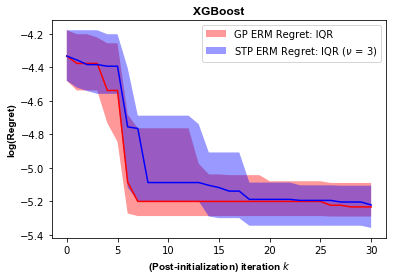

In [101]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_loser, color = 'Red')
plt.plot(median_winner, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_loser, upper_loser, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_winner, upper_winner, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
